In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import matplotlib as mpl

dpi = 200
mpl.rcParams['figure.dpi'] = dpi
sns.set_context("notebook")

import pandas as pd
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *

### Load in data

In [4]:
savedir = "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/model/"

In [5]:
ds = xr.open_dataset(
        datadir("/model/Southern_Ocean_WMT_Budget.nc"))

ds["BF_Adv"] = ds["surface_ocean_flux_advective_negative_rhs"]
ds["BF_NonAdv"] = ds["boundary_fluxes"] - ds["BF_Adv"]

ds["surface_boundary_fluxes"] = ds["boundary_fluxes"] - ds["bottom_flux_heat"]

ds["boundary_fluxes_heat"] = ds["surface_ocean_flux_advective_negative_rhs_heat"] +\
                                 ds["surface_exchange_flux_heat"] +\
                                 ds["frazil_ice_heat"] + ds["bottom_flux_heat"]

ds["boundary_fluxes_salt"] = ds["surface_ocean_flux_advective_negative_rhs_salt"] +\
                                 ds["surface_exchange_flux_salt"]
ds["other_bf_terms"] = ds["boundary_fluxes"] - (ds["surface_ocean_flux_advective_negative_rhs_salt"] + ds["surface_exchange_flux_heat"])

ds["other_plot_terms"] = ds["mass_source"] + ds["other_bf_terms"]


### Extract water mass budget

The closed numerical $\lambda$-WMT budget is given in Drake et. al 2024's Equation 43. The budget is given by: 
$$-\partial_t \mathcal{M}_\geq + \mathcal{S}_\geq + \Psi_\geq + \mathcal{G}^{BF}_\geq + \mathcal{G}^{Mix}_\geq + \mathcal{G}^{Spurious}_\geq = 0$$

Here: 
- $ \mathcal{M}(\tilde \lambda, t)_\geq = \int_\Omega \rho dV $ is the set of all waters bounded by a material surface $\tilde \lambda$
-  $\partial_t \mathcal{M}_\geq$ the rate of change of the mass of that water that is bounded by $\tilde \lambda$
    - $\tilde \lambda$ can be a density, so that $\partial_t \mathcal{M}_\geq$ describes the actual mass of waters denser than $\tilde \lambda$
    - When $\tilde \lambda$ is a density surface, $\partial_t \mathcal{M}_\geq > 0$ implies the mass of waters denser than $\tilde \lambda$ is decreasing
- If the region $\omega$ contains open boundaries (i.e. the focus is on a particular ocean), then mass is not conserved. Mass can enter freely via ocean circulation. This movement of mass along the horizontal boundaries is given by $\Psi_\geq$.
- $\mathcal{G}^{BF}_\geq$ is the contribution of mass change from boundary fluxes including mixing processes at the surface, seafloor and sea-ice.
- $\mathcal{G}^{Mix}_\geq$ includes the effects of parameterized mixing
- $\mathcal{G}^{Spurious}_\geq$ includes the effects of spurios mixing, from a models advection scheme. Obtained as a residual. 


In [11]:
toTg = 1e-9 

mass_flux_units = "Tg/s"
mass_flux_units_conversion = toTg #kg to Tg 

In [12]:
integrate = lambda dx: np.cumsum(np.concatenate([[0], dx.values]))

In [43]:
experiments = ['forced', 'control']
nexpt = len(experiments)
ds["bf_other_terms"] = ds["boundary_fluxes_heat"] + ds["boundary_fluxes_salt"] - (ds["surface_exchange_flux_heat"] + ds["surface_ocean_flux_advective_negative_rhs_salt"])

budgets = ['mass_tendency', 
           'surface_boundary_fluxes',
           # 'surface_ocean_flux_advective_negative_rhs_salt',
           'diffusion', 
           'spurious_numerical_mixing',
           'convergent_mass_transport', 
           "bottom_flux_heat",
           ]

budgets_labels = [r"$\partial_{t} \mathcal{M}_\geq$", 
                  # r"$\mathcal{G}^{SFC, \theta}_\geq$",
                  # r"$\mathcal{G}^{SFC, FW}_\geq$",
                  r"$\mathcal{G}^{SFC}_\geq$",
                  r"$\mathcal{G}^{mix}_\geq$",
                  r"$\mathcal{G}^{Spu}_\geq$",
                  r"$\Psi_\geq$", 
                  r"$\mathcal{G}^{\theta_{BOT}}_\geq$", 
                  ]
times = [("2050", "2100")]

alphas = [1, 0.4, 0.4, 0.4, 1, 0.4]
ncols = len(times)

expt_colors = dict(); expt_colors["control"] = "#2f74b3"; expt_colors["forced"] = "#cc415a"

# Define the muted color palette
palette = sns.color_palette("tab10", len(budgets))

# Manually pick muted purple and brown from the palette
muted_purple = sns.color_palette("muted")[4]  # Approximate purple in "muted"
muted_brown = sns.color_palette("muted")[5]   # Approximate brown in "muted"

# Define custom colors for specific budgets
custom_colors = {
    "mass_tendency": muted_purple,
    "convergent_mass_transport": muted_brown,
}

# Generate colors for remaining variables
remaining_budgets = [budget for budget in budgets if budget not in custom_colors]
remaining_palette = sns.color_palette("muted", len(remaining_budgets))
remaining_colors = {budget: remaining_palette[i] for i, budget in enumerate(remaining_budgets)}

# Combine the custom colors and remaining colors into one dictionary
var_colors = {**custom_colors, **remaining_colors}

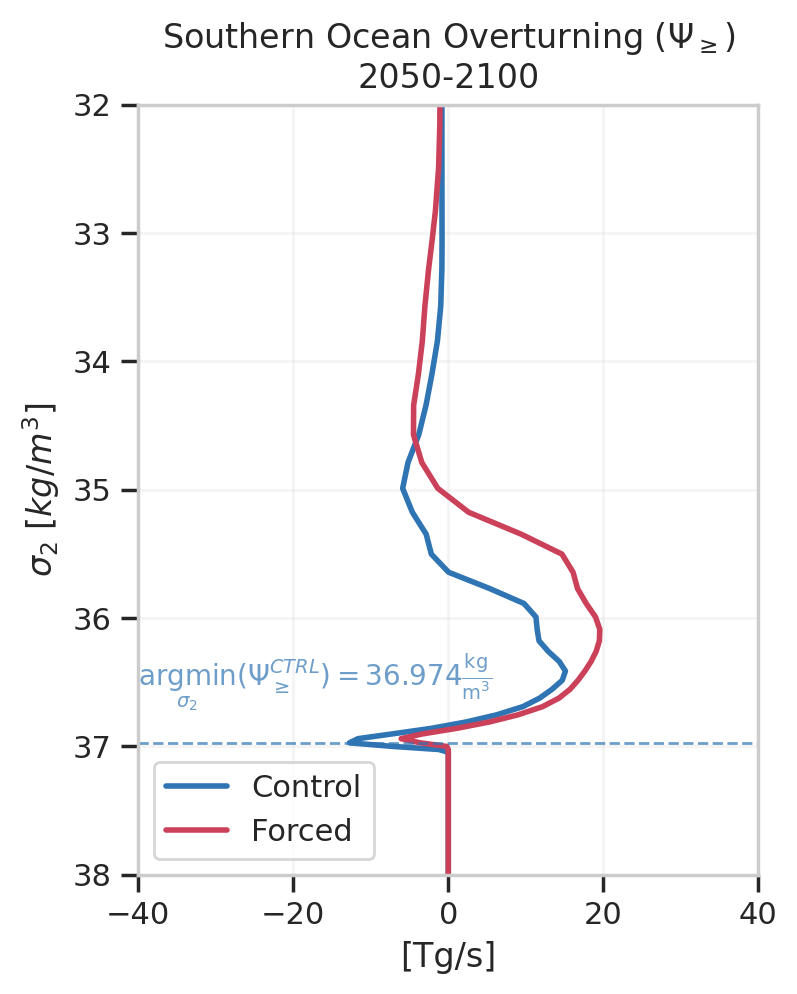

In [150]:
times = ("2050", "2100")
ds_mean = ds.sel(time = slice(times[0], times[1])).mean("time")
fig, ax = plt.subplots(figsize = (4, 5),sharey = True, sharex = True)

ax.set_title("Southern Ocean Overturning" + r" $(\Psi_\geq)$" + "\n2050-2100")
ax.plot(mass_flux_units_conversion * ds_mean.sel(exp = "control")['convergent_mass_transport'], 
           ds_mean.sigma2_l_target, lw = 2.0, label = "Control",
          c = expt_colors['control'])
ax.plot(mass_flux_units_conversion * ds_mean.sel(exp = "forced")['convergent_mass_transport'], 
           ds_mean.sigma2_l_target, lw = 2.0, label = "Forced", 
          c = expt_colors['forced'])

ax.axhline([36.974], c = expt_colors['control'], alpha = 0.7, lw = 1, linestyle = "--")
ax.annotate(r'$\underset{\sigma_2}{\mathrm{argmin}} (\Psi^{CTRL}_\geq)$' + r'$= 36.974 \mathrm{\frac{kg}{m^3}}$', 
            xy=(-40., 36.5), fontsize = 10, 
            xytext=(0, 0), textcoords="offset points",
            va="center", c = expt_colors['control'], alpha = 0.7)

ax.legend(loc = "lower left", markerscale=0.5)
# [a.legend() for a in ax]
ax.set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
ax.set_xlabel("[Tg/s]")
ax.set_ylim(32, 38)
ax.set_xlim(-40, 40)
ax.invert_yaxis()
ax.grid(alpha = 0.2)
ax.tick_params(bottom=True, left=True)
fig.savefig(plotsdir("paper_figures/SO_Psi_Profile.png"), dpi = 200, bbox_inches = "tight")

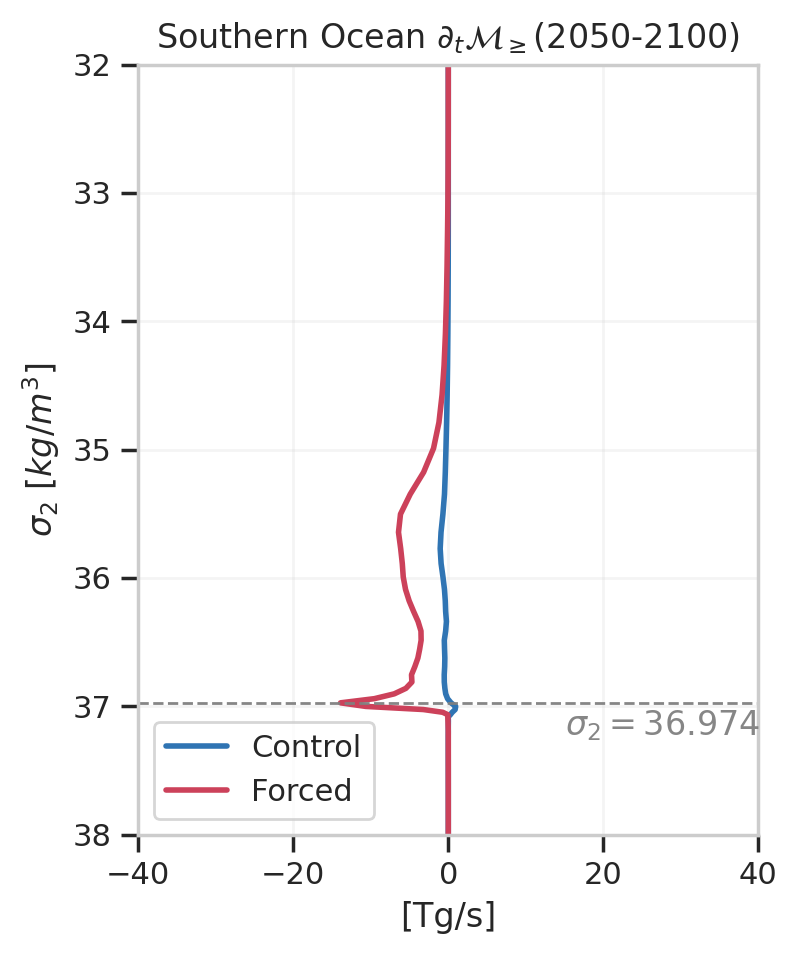

In [152]:
times = ("2050", "2100")
ds_mean = ds.sel(time = slice(times[0], times[1])).mean("time")
fig, ax = plt.subplots(figsize = (4, 5),sharey = True, sharex = True)

ax.set_title("Southern Ocean " + r"$\partial_{t} \mathcal{M}_\geq$" + "(2050-2100)")
ax.plot(mass_flux_units_conversion * ds_mean.sel(exp = "control")['mass_tendency'], 
           ds_mean.sigma2_l_target, lw = 2.0, label = "Control",
          c = expt_colors['control'])
ax.plot(mass_flux_units_conversion * ds_mean.sel(exp = "forced")['mass_tendency'], 
           ds_mean.sigma2_l_target, lw = 2.0, label = "Forced", 
          c = expt_colors['forced'])

ax.axhline([36.974], c = "grey", alpha = 0.95, lw = 1, linestyle = "--")
ax.annotate(r"$\sigma_2 = 36.974$", xy=(15., 37.15), fontsize = 12,
              xytext=(0, 0), textcoords="offset points",
              va="center", c = "grey", alpha = 0.95)

ax.legend(loc = "lower left", markerscale=0.5)
# [a.legend() for a in ax]
ax.set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
ax.set_xlabel("[Tg/s]")
ax.set_ylim(32, 38)
ax.set_xlim(-40, 40)
ax.invert_yaxis()
ax.grid(alpha = 0.2)
ax.tick_params(bottom=True, left=True)
fig.savefig(plotsdir("paper_figures/SO_dMdt_Profile.png"), dpi = 200, bbox_inches = "tight")

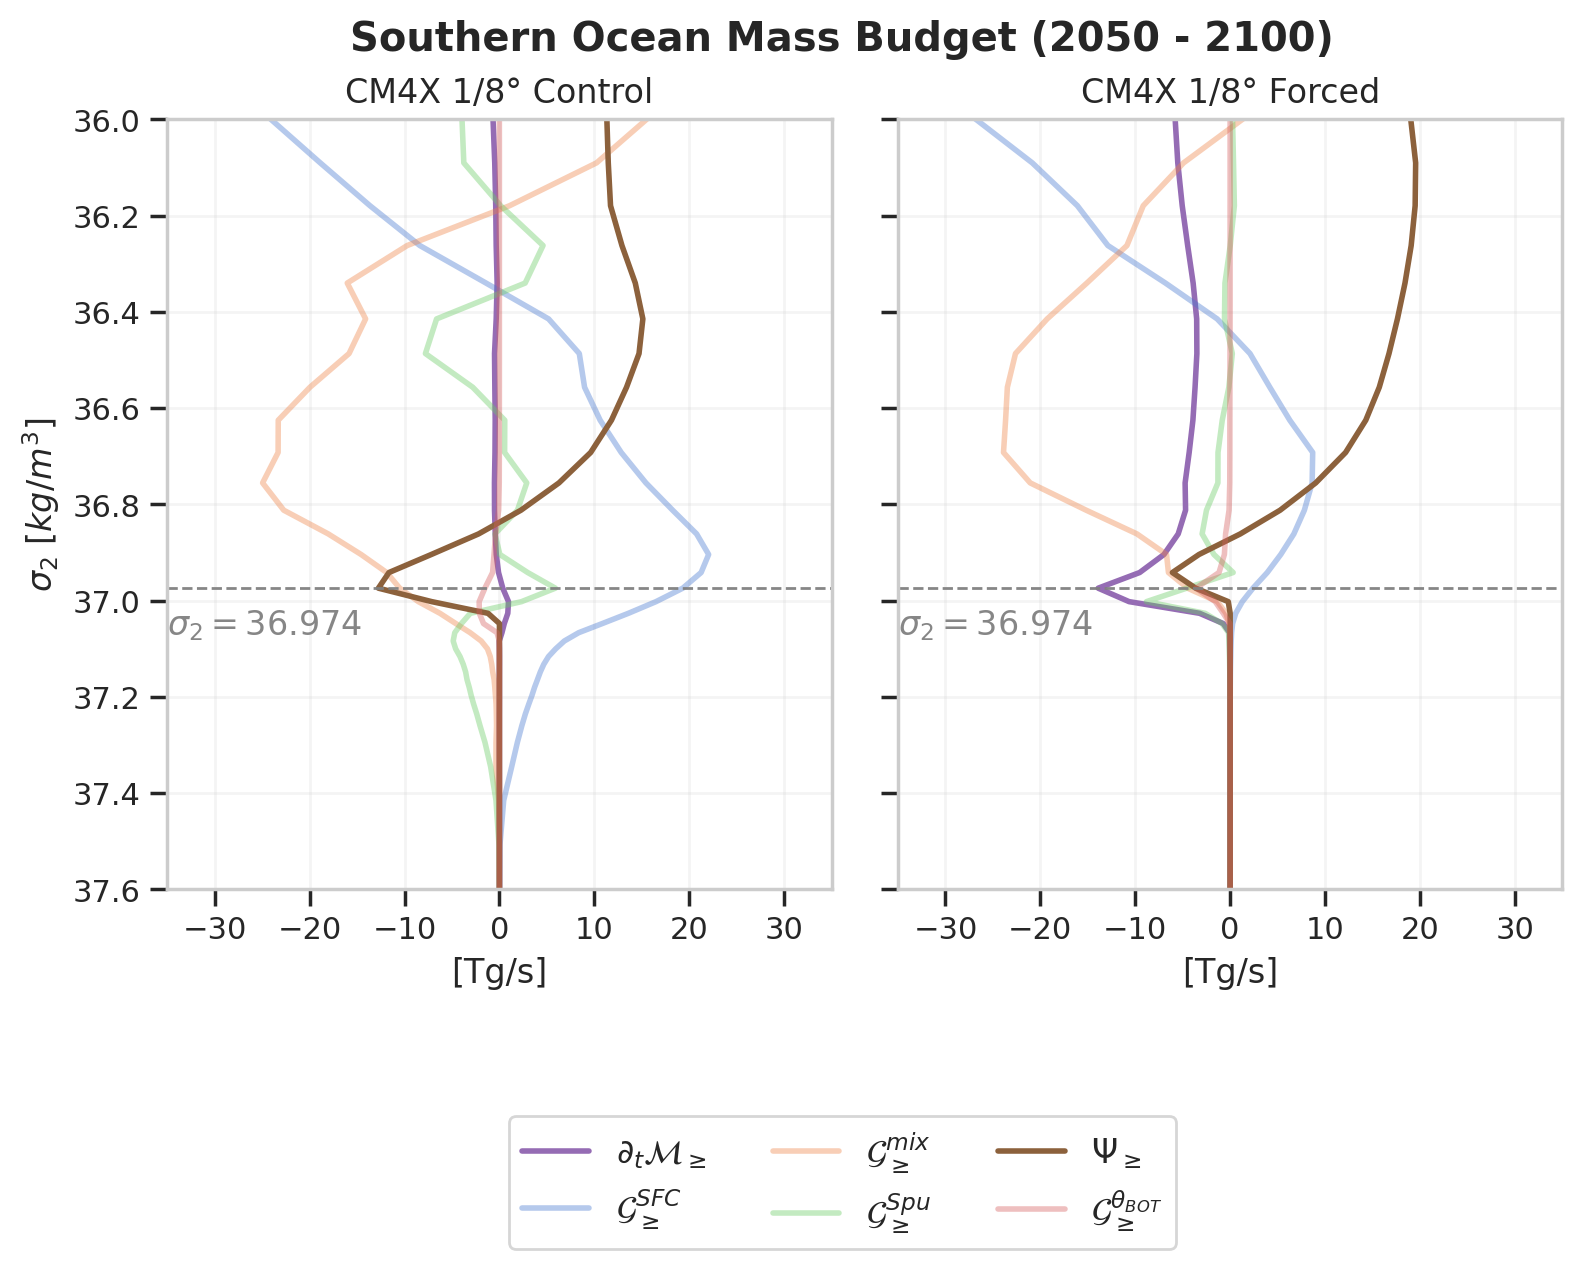

In [153]:
times = ("2050", "2100")
ds_mean = ds.sel(time = slice(times[0], times[1])).mean("time")
fig, ax = plt.subplots(1, 2, figsize = (9, 5),sharey = True, sharex = True)
fig.suptitle("Southern Ocean Mass Budget (2050 - 2100)", fontweight = "bold")
for (i, exp) in enumerate(budgets):
    ax[1].set_title("CM4X 1/8° Forced")
    ax[1].plot(mass_flux_units_conversion * ds_mean.sel(exp = "forced")[exp], 
               ds_mean.sigma2_l_target, 
               label = budgets_labels[i], lw = 2.0,alpha = alphas[i], 
              c = var_colors[exp])
    ax[0].set_title("CM4X 1/8° Control")
    ax[0].plot(mass_flux_units_conversion * ds_mean.sel(exp = "control")[exp], 
               ds_mean.sigma2_l_target,
               # label = budgets_labels[i], 
               lw = 2.0,alpha = alphas[i], 
              c = var_colors[exp])

for a in ax:
    a.axhline([36.974], c = "grey", alpha = 0.95, lw = 1, linestyle = "--")
    a.annotate(r"$\sigma_2 = 36.974$", xy=(-35., 37.05), fontsize = 12,
                      xytext=(0, 0), textcoords="offset points",
                      va="center", c = "grey", alpha = 0.95)
    a.tick_params(bottom=True, left=True)
# ax[0].legend()
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize = 12)
fig.subplots_adjust(wspace = 0.1)
ax[0].set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
[a.set_xlabel("[Tg/s]") for a in ax]
ax[1].set_ylim(36, 37.6)
ax[1].set_xlim(-35, 35)
ax[1].invert_yaxis()
[a.grid(alpha = 0.2) for a in  ax]
fig.savefig(plotsdir("paper_figures/Mass_Budget_Profile_Budget.png"), dpi = 200, bbox_inches = "tight")

In [157]:
# sigma = 37.00
sigma = 36.974
times = [("2050", "2100")]

In [158]:
tendencies = mass_flux_units_conversion * ds.sel(sigma2_l_target = sigma, method = "nearest").compute()
tendencies = tendencies.groupby("time.year").mean("time")
tendencies = tendencies.sel(year = slice("1850", None))

-13.90471660729884
0.3515832225817309


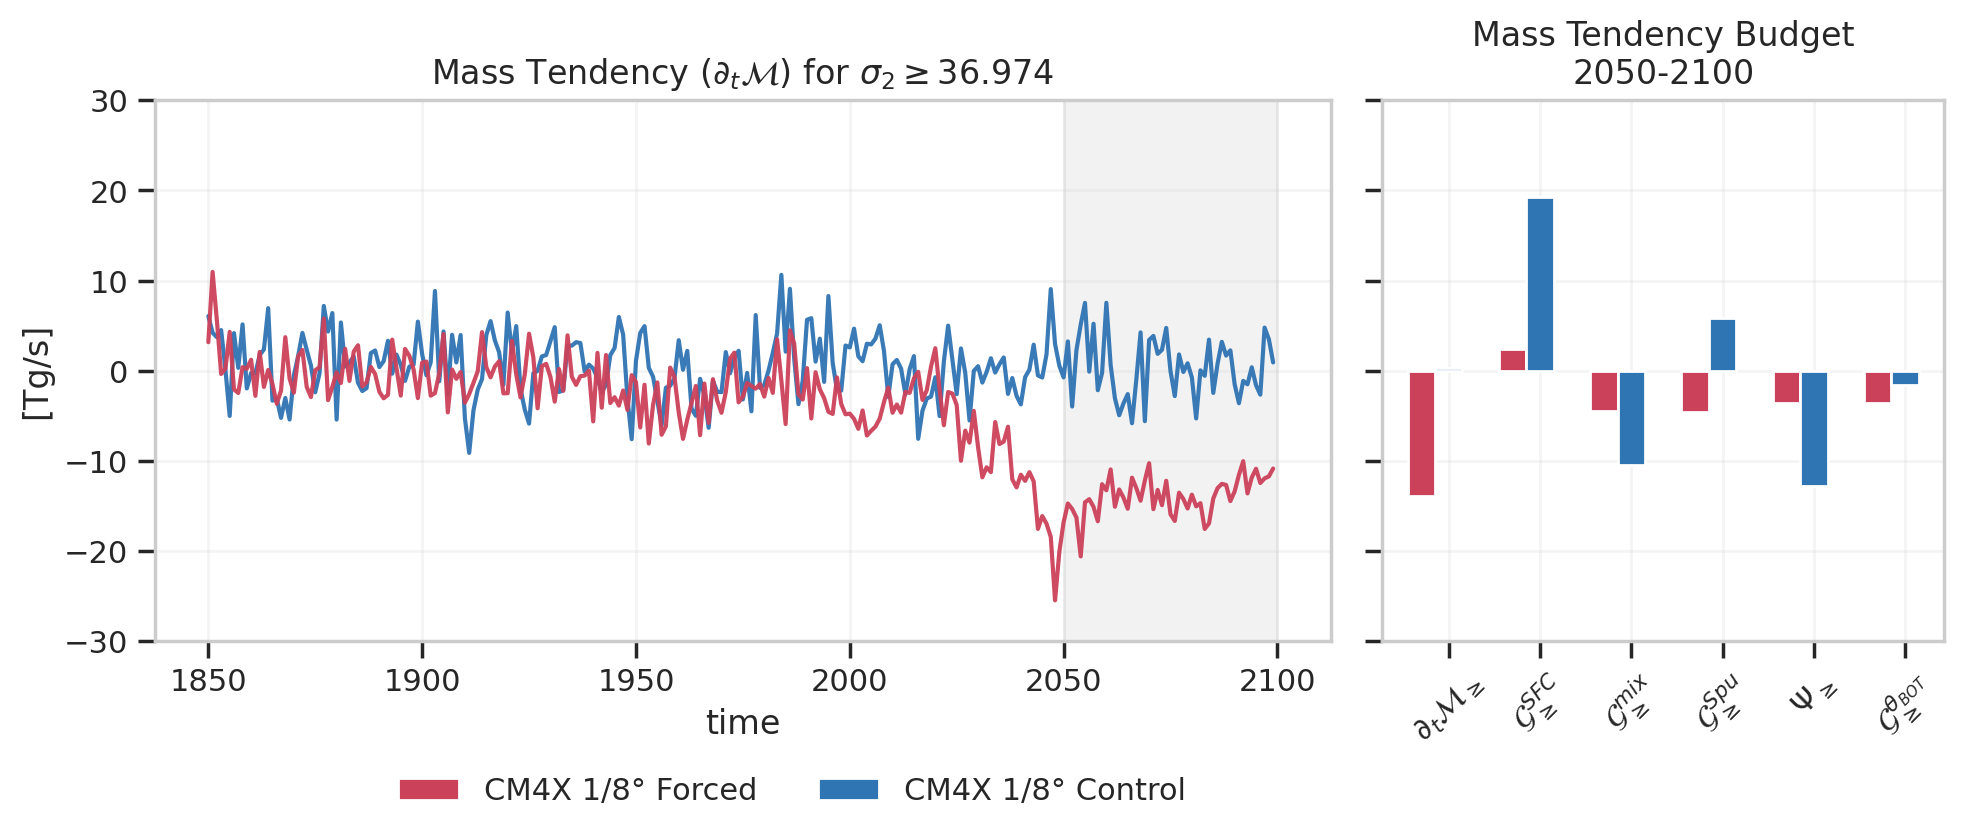

In [171]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(10, 4))

# Create a GridSpec with 4 columns, where the first plot takes up 3/4 and the second takes 1/4
gs = gridspec.GridSpec(1, 6)

###### PLOT 1. TIME SERIES ###########
ax1 = fig.add_subplot(gs[0, :4])
ax = ax1
ax.grid(alpha = 0.4, axis = "y")
width = 0.3

ax.grid(alpha = 0.2)

ax.plot(tendencies.year, tendencies["mass_tendency"].sel(exp = "control"), 
        label = "CM4Xp125\ncontrol", linewidth = 1.5, alpha = 0.95, c = expt_colors["control"])

ax.plot(tendencies.year, tendencies["mass_tendency"].sel(exp = "forced"), 
        label = "CM4Xp125\nforced", linewidth = 1.5, alpha = 0.95, c = expt_colors["forced"])

ax.set_ylabel(f"[{mass_flux_units}]")

ax.set_title("Mass Tendency " + r"$(\partial_{t} \mathcal{M})$" + " for " + r"$\sigma_2 \geq 36.974$")
ax.set_xlabel("time")
ax.tick_params(bottom=True, left=True)

ax.axvspan(2050, 2100, color='grey' , alpha=0.1, zorder = 0)

###### PLOT 2. BAR PLOT ###########
ax2 = fig.add_subplot(gs[0, 4:], sharey = ax1)
ax = ax2
for (it, t) in enumerate(times):
    wmt_mean = mass_flux_units_conversion * ds.sel(sigma2_l_target = sigma, method = "nearest")
    wmt_mean = wmt_mean.sel(time = slice(t[0], t[1])).mean("time")
    curr_width = 0.0
    for (i, exp) in enumerate(experiments):

        wmt_mean_budget =  wmt_mean.sel(exp = exp)
        print(wmt_mean_budget['mass_tendency'].values)
        bvalues = [wmt_mean_budget[k].values for k in budgets]
    
        nterms = np.arange(len(budgets_labels))
    
        ax.bar(nterms + curr_width, bvalues, label = "CM4X 1/8° " + exp.capitalize(), 
                  width = width, color = expt_colors[exp])
        curr_width += width
    
ax.grid(alpha = 0.2)
ax.set_xticks(np.arange(len(budgets_labels)) + width, budgets_labels, rotation = 45)
ax.set_title("Mass Tendency Budget\n" + '-'.join(t))
# ax.set_ylabel(f"[{mass_flux_units}]")
fig.tight_layout()
ax.legend(ncols = 2, bbox_to_anchor = (-0.3, -0.2), frameon = False)
ax.tick_params(bottom=True, left=True, labelleft=False)
fig.subplots_adjust(wspace = 0.2)
[a.set_ylim(-30, 30) for a in [ax1, ax2]]
fig.savefig(plotsdir(f"paper_figures/dMdt_sigma_{sigma}.png"), bbox_inches = "tight", dpi = dpi)

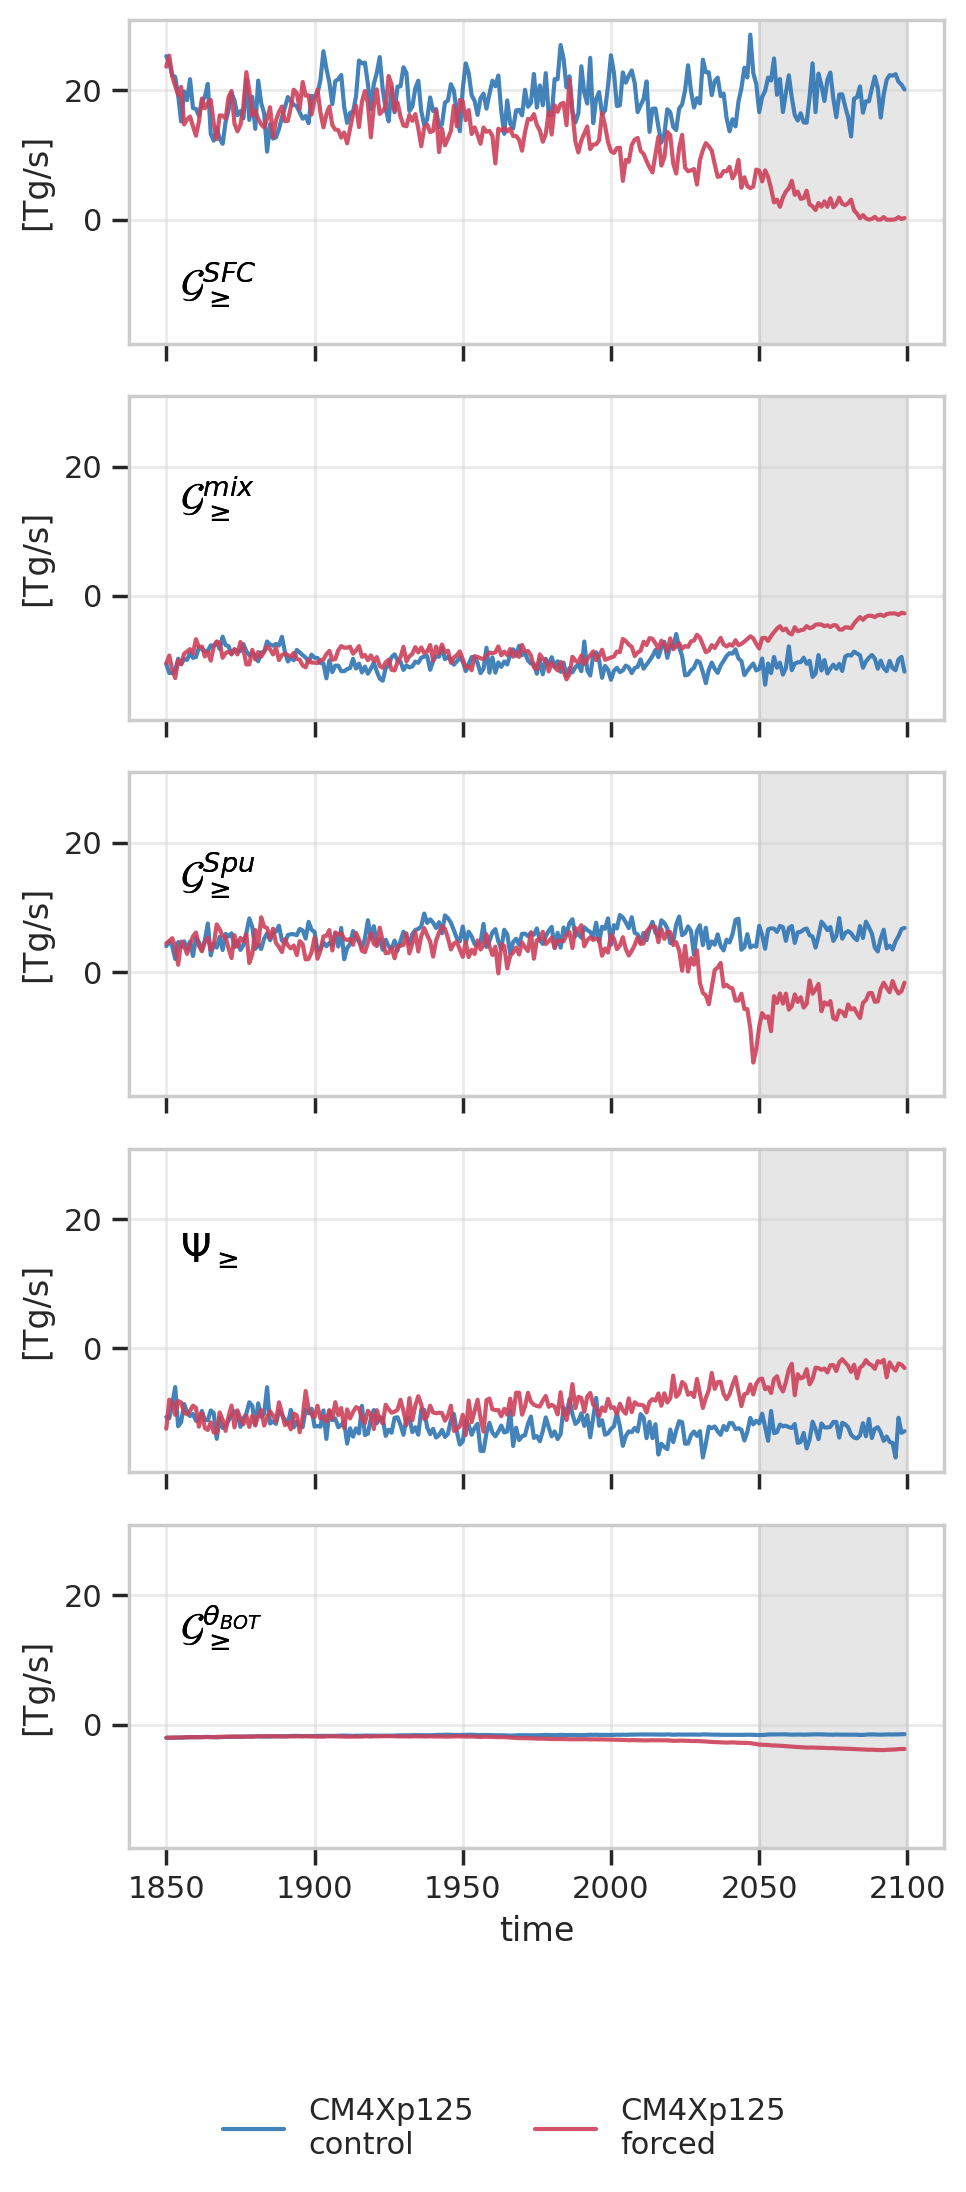

In [172]:
tendencies = mass_flux_units_conversion * ds.sel(sigma2_l_target = sigma, method = "nearest").compute()

tendencies_std = tendencies.groupby("time.year").std("time")
tendencies_std = tendencies_std.sel(year = slice("1850", None))

tendencies = tendencies.groupby("time.year").mean("time")
tendencies = tendencies.sel(year = slice("1850", None))

budget_colors = sns.color_palette("Dark2")

budgets = ['surface_boundary_fluxes',
           # 'surface_exchange_flux_heat',
           # 'surface_ocean_flux_advective_negative_rhs_salt',
           'diffusion', 
           'spurious_numerical_mixing',
           'convergent_mass_transport', 
           "bottom_flux_heat",
           ]

budgets_labels = [r"$\mathcal{G}^{SFC}_\geq$",
                  # r"$\mathcal{G}^{SFC, \theta}_\geq$",
                  # r"$\mathcal{G}^{SFC, FW}_\geq$",
                  r"$\mathcal{G}^{mix}_\geq$",
                  r"$\mathcal{G}^{Spu}_\geq$",
                  r"$\Psi_\geq$", 
                  r"$\mathcal{G}^{\theta_{BOT}}_\geq$", 

                  ]

fig, axes = plt.subplots(len(budgets), 1, figsize = (5, 10), 
                         sharex = True, sharey = True)

for (j, expt) in enumerate(["control", "forced"]):
    for i in range(len(budgets)):
        ax = axes[i]
        ax.grid(alpha = 0.4)
        ax.plot(tendencies.year, tendencies[budgets[i]].sel(exp = expt), 
                label = f"CM4Xp125\n{expt}", linewidth = 1.5, 
                alpha = 0.9, c = expt_colors[expt])
            
        ax.tick_params(bottom=True, left=True)
        ax.axvspan(2050, 2100, color='grey' , alpha=0.1, zorder = 0)
        # ax.set_title(budgets_labels[i])

        if i == 0: 
            xy = (1850, -10)    
        else: 
            xy = (1850, 15)    
        ax.annotate(budgets_labels[i], xy=xy, fontsize = 14, 
                    xytext=(5, 0), textcoords="offset points",
                  va="center", c = "k")
        
[a.set_ylabel(f"[{mass_flux_units}]") for a in axes]
# [ax.set_xlabel("time") for ax in axes[2:4]]
axes[-1].set_xlabel("time")

fig.subplots_adjust(hspace = 0.25, wspace = 0.1)
fig.tight_layout()
axes[-1].legend(ncols = 2, loc = (0.1, -1), frameon = False)
fig.savefig(plotsdir(f"paper_figures/budget_sigma_{sigma}.png"), 
            bbox_inches = "tight", dpi = dpi)

### Seasonality of advection and mixing terms

#### Seasonality of advection terms

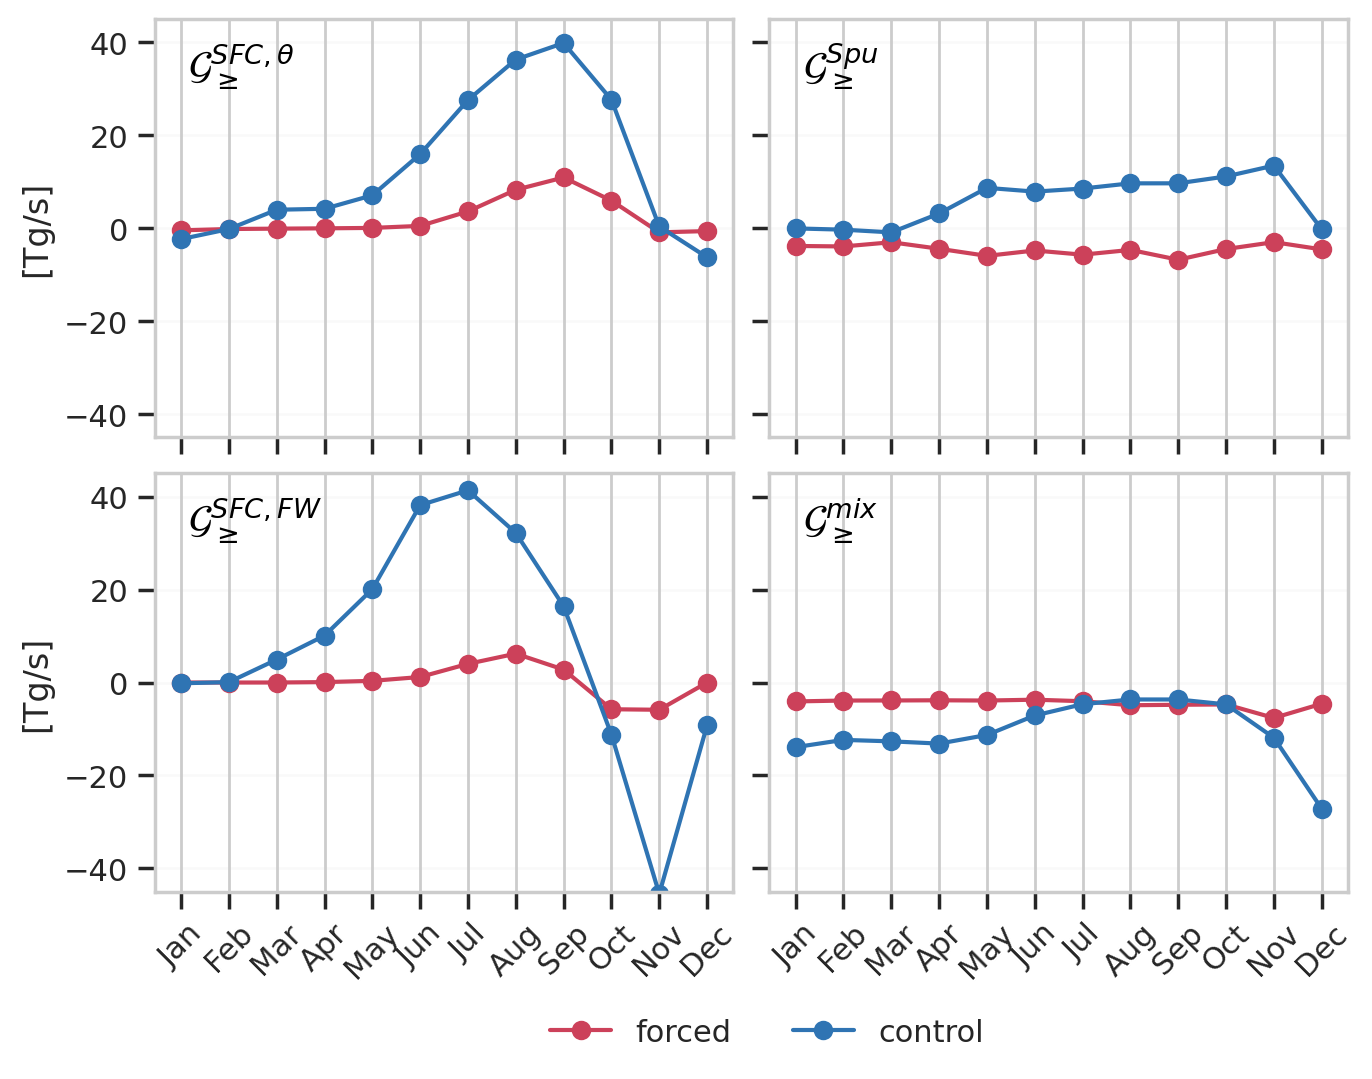

In [173]:
experiments = ['forced', 'control']
nexpt = len(experiments)

fig, ax = plt.subplots(2, 2, figsize = (7, 5), sharey = True, sharex = True)

width = 0.25
times = ("2050", "2100")

wmt_mean = mass_flux_units_conversion * ds.sel(sigma2_l_target = sigma, method = "nearest")
wmt_mean = wmt_mean.sel(time = slice(times[0], times[1])).groupby("time.month").mean("time")
max_flux =  np.abs(wmt_mean.sel(exp = "control")["boundary_fluxes_heat"]).max() + 5
bvars = ["surface_exchange_flux_heat", "spurious_numerical_mixing", "surface_ocean_flux_advective_negative_rhs_salt", "diffusion"]
bvars_labels = [r"$\mathcal{G}^{SFC, \theta}_\geq$",
                r"$\mathcal{G}^{Spu}_\geq$", 
                  r"$\mathcal{G}^{SFC, FW}_\geq$",
                  r"$\mathcal{G}^{mix}_\geq$"]
ax[0, 0].set_ylim(-45, 45)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for (j, var) in enumerate(bvars):
    for (i, exp) in enumerate(experiments):
        wmt_mean_budget =  wmt_mean.sel(exp = exp)[var]
        ax.flatten()[j].plot(wmt_mean_budget.month * 1.75, wmt_mean_budget, 
                             marker = "o", label = exp, color = expt_colors[exp])
    ax.flatten()[j].annotate(bvars_labels[j], xy=(1.5, 35), fontsize = 14, 
                xytext=(5, 0), textcoords="offset points",
                va="center", c = "k", zorder = 100)
    
ax[0, 0].set_ylabel(f"[{mass_flux_units}]")
ax[1, 0].set_ylabel(f"[{mass_flux_units}]")

fig.tight_layout()


[a.grid(alpha = 0.1, axis = "y") for a in ax.flatten()]
[a.set_xticks(wmt_mean_budget.month * 1.75, months, rotation = 45) for a in ax.flatten()[2:]];

[a.tick_params(bottom=True, left=True) for a in ax.flatten()];
ax[1, 1].legend(ncols = 3, loc = (-0.4, -0.4), frameon = False)

fig.savefig(plotsdir(f"paper_figures/SeasonalBudget_sigma_{sigma}.png"), bbox_inches = "tight", dpi = dpi)

#### Seasonality of mixing terms

### Spatial patterns of advection and tendency terms

In [174]:
ds_sfc = xr.open_dataset(datadir(f"/model/Southern_Ocean_Surface_Advection_and_Tendency_sigma_{sigma}.nc"))

In [186]:
ds_sfc["surface_ocean_flux_advective_negative_rhs"] = ds_sfc["surface_ocean_flux_advective_negative_rhs_heat"] + ds_sfc["surface_ocean_flux_advective_negative_rhs_salt"]
ds_sfc["BF_Adv"] = ds_sfc["surface_ocean_flux_advective_negative_rhs"]
ds_sfc["BF_NonAdv"] = ds_sfc["boundary_fluxes"] - ds_sfc["BF_Adv"]

ds_sfc["surface_boundary_fluxes"] = ds_sfc["boundary_fluxes"] - ds_sfc["bottom_flux_heat"]

ds_sfc["boundary_fluxes_heat"] = ds_sfc["surface_ocean_flux_advective_negative_rhs_heat"] +\
                                 ds_sfc["surface_exchange_flux_heat"] +\
                                 ds_sfc["frazil_ice_heat"] + ds_sfc["bottom_flux_heat"]

ds_sfc["boundary_fluxes_salt"] = ds_sfc["surface_ocean_flux_advective_negative_rhs_salt"] +\
                                 ds_sfc["surface_exchange_flux_salt"]

ds_sfc["diffusion"] = ds_sfc["diffusion_salt"] +  ds_sfc["diffusion_heat"]

# ds_sfc["spurious_mixing_psi_ratio"] = ds_sfc["spurious_numerical_mixing"].where((ds_sfc["spurious_numerical_mixing"] != 0.0) / \
#                                       ds_sfc["convergent_mass_transport"].where((ds_sfc["convergent_mass_transport"] != 0.0)

In [187]:
mass_flux_units_conversion = toTg / (ds_sfc.areacello / (100e3 **2 ))
mass_flux_units = r"$Tg/100^2 km^2 / s$"

In [208]:
import matplotlib.patches as  mpath
from matplotlib.colors import BoundaryNorm, ListedColormap
import cartopy.feature as cfeature

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

def plot_antarctic_plot(ds, ax, cmap = None, norm = None, 
                        exp = "forced", variable = "mass_tendency", mass_flux_units_conversion = 1):

    wmt_mean_budget =  mass_flux_units_conversion * ds.sel(exp = exp)[variable]
    # wmt_mean_budget = wmt_mean_budget.where(wmt_mean_budget != 0.0)
    wmt_mean_budget = wmt_mean_budget.where(np.abs(wmt_mean_budget) > 1e-8)
    cm = ax.pcolormesh(wmt_mean_budget.geolon, wmt_mean_budget.geolat, 
                         wmt_mean_budget, cmap = cmap, transform=ccrs.PlateCarree(), 
                        norm = norm)
    ax.coastlines();
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')

    # Draw meridian lines with labels around circular boundary
    gls = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, \
                    xlocs=range(-180,171,45), ylocs=range(-90,0,10), \
                    color='gray', alpha=0.25, linestyle='-', zorder=10, 
                    xlabel_style = {"fontsize":9.5})

    
    ax.set_boundary(circle, transform=ax.transAxes)

    return cm

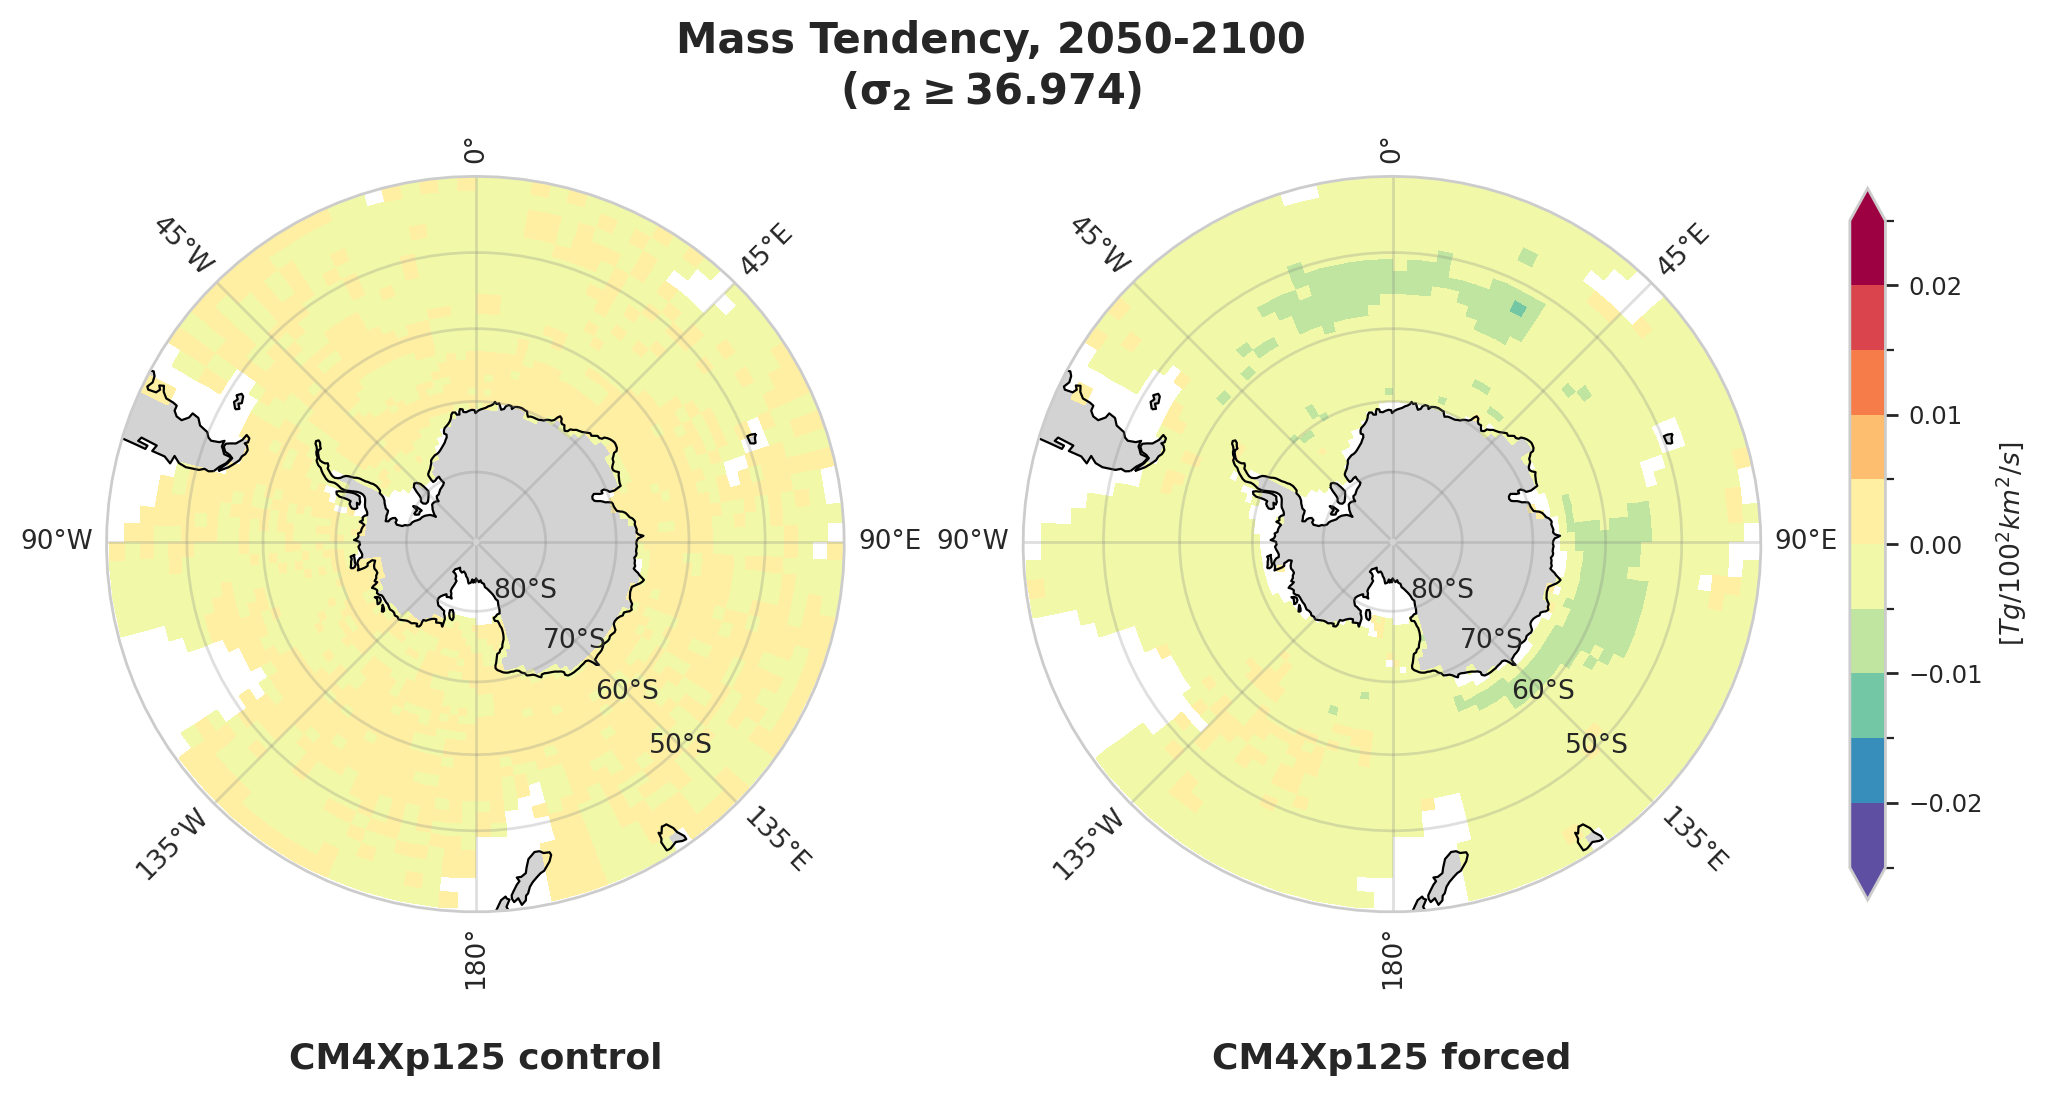

In [209]:
experiments = ['control', 'forced']
nexpt = len(experiments)
sns.set_style("whitegrid")
sns.set_context("paper")
mpl.rcParams['figure.dpi'] = 200

density_title = r"$\mathbf{(\sigma_2 \geq 36.974)}$"
cmap = plt.get_cmap('Spectral_r')
# boundaries = np.arange(-0.02, 0.0201, 0.005)
# boundaries = np.arange(-0.05, 0.0501, 0.01)
boundaries = np.arange(-0.05, 0.0501, 0.01) / 2

boundaries[np.abs(boundaries) < 1e-16]  = 0
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)

fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = ("2050", "2100")

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):
    cm = plot_antarctic_plot(wmt_mean, ax[i], cmap = cmap, norm = norm, 
                       exp = exp, variable = "mass_tendency", 
                        mass_flux_units_conversion = mass_flux_units_conversion)
        
fig.suptitle("Mass Tendency, " + '-'.join(times) + "\n" + density_title, 
             fontweight = "bold", fontsize = 15, ha='center')


fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both")

fig.savefig(plotsdir(f"paper_figures/dMdt_sigma_{sigma}_surface.png"), bbox_inches = "tight", dpi = dpi)

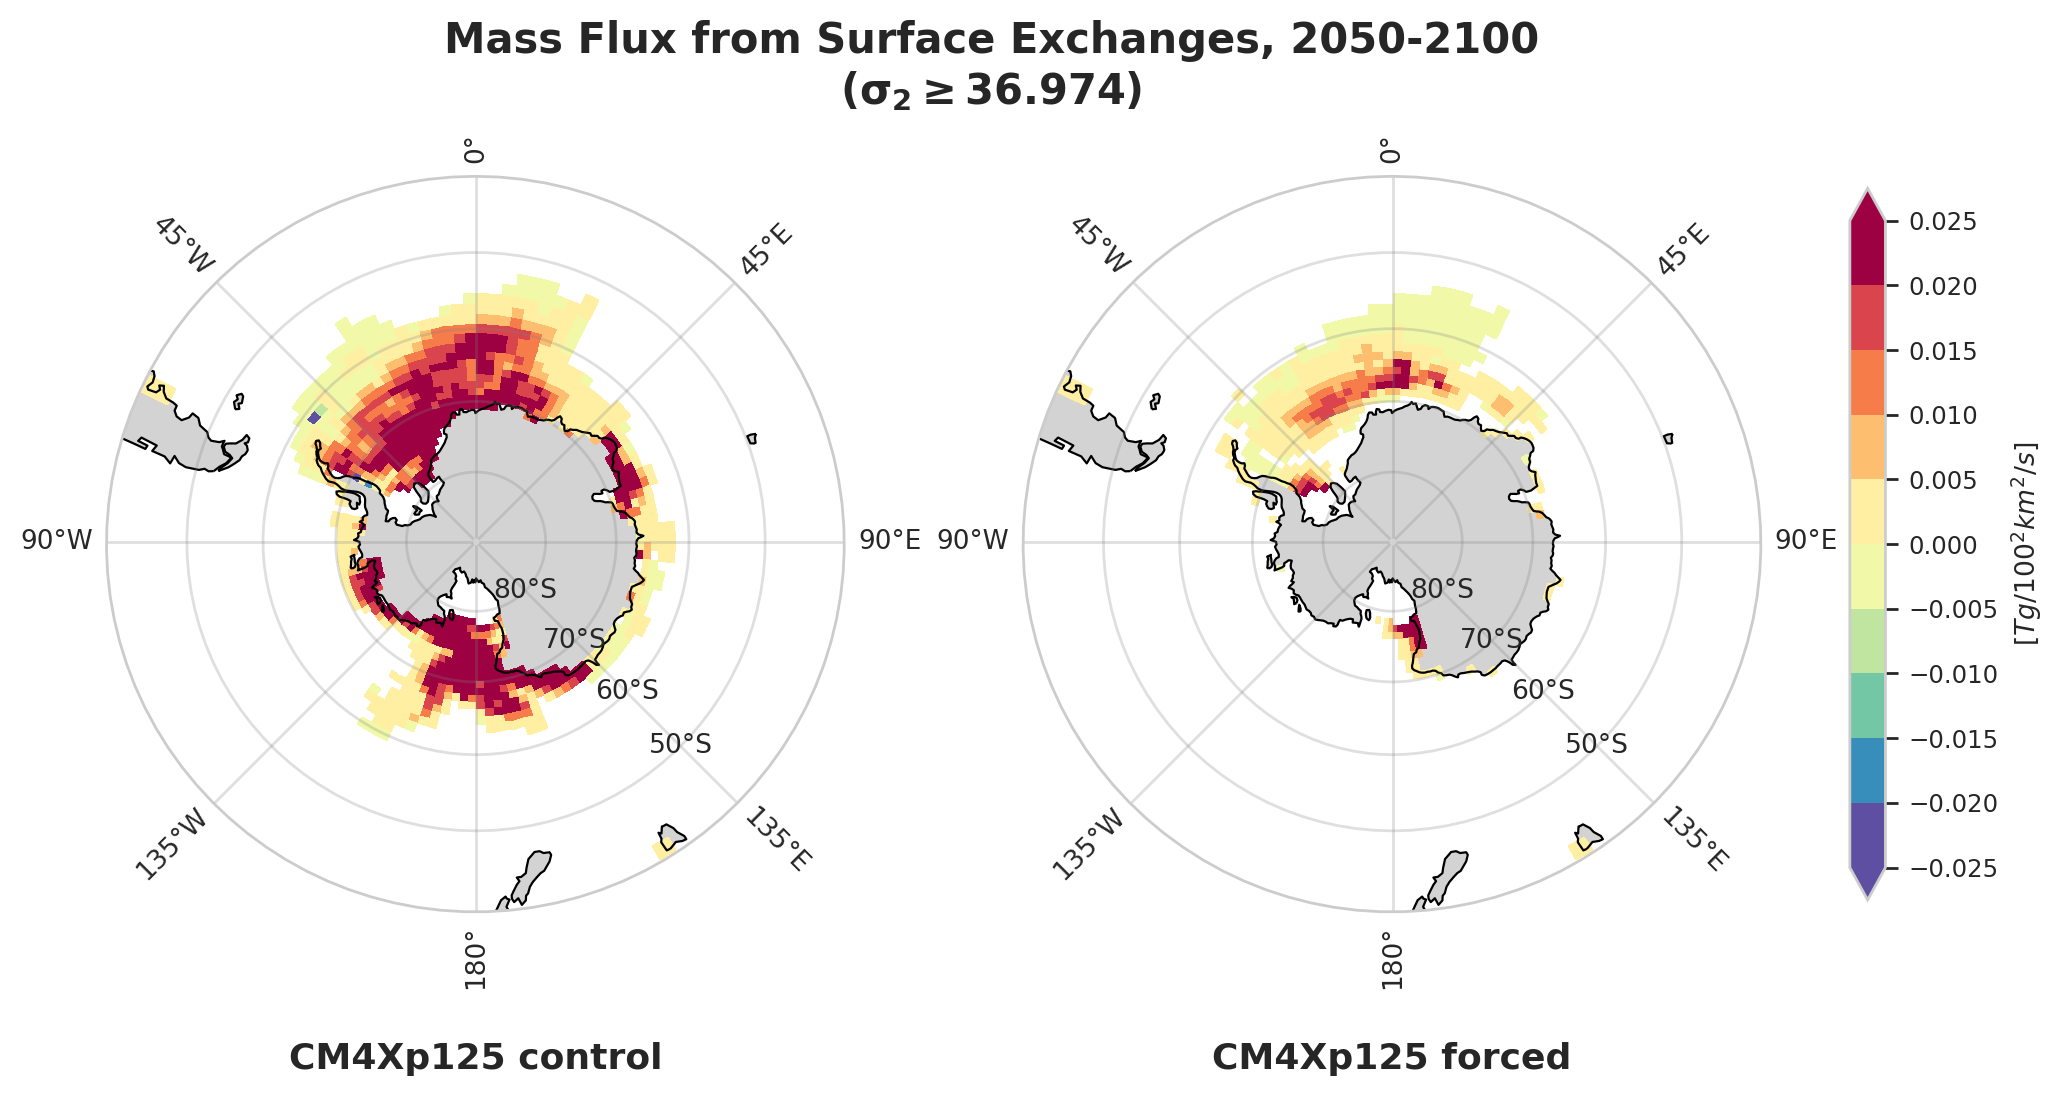

In [210]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = ("2050", "2100")

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):
    cm = plot_antarctic_plot(wmt_mean, ax[i], cmap = cmap, norm = norm, 
                       exp = exp, variable = "surface_boundary_fluxes", 
                        mass_flux_units_conversion = mass_flux_units_conversion)
fig.suptitle("Mass Flux from Surface Exchanges, " + '-'.join(times) + "\n" + density_title, 
             fontweight = "bold", fontsize = 15)


fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both", ticks=boundaries)

fig.savefig(plotsdir(f"paper_figures/GSFC_exchange_sigma_{sigma}_surface.png"), bbox_inches = "tight", dpi = dpi)

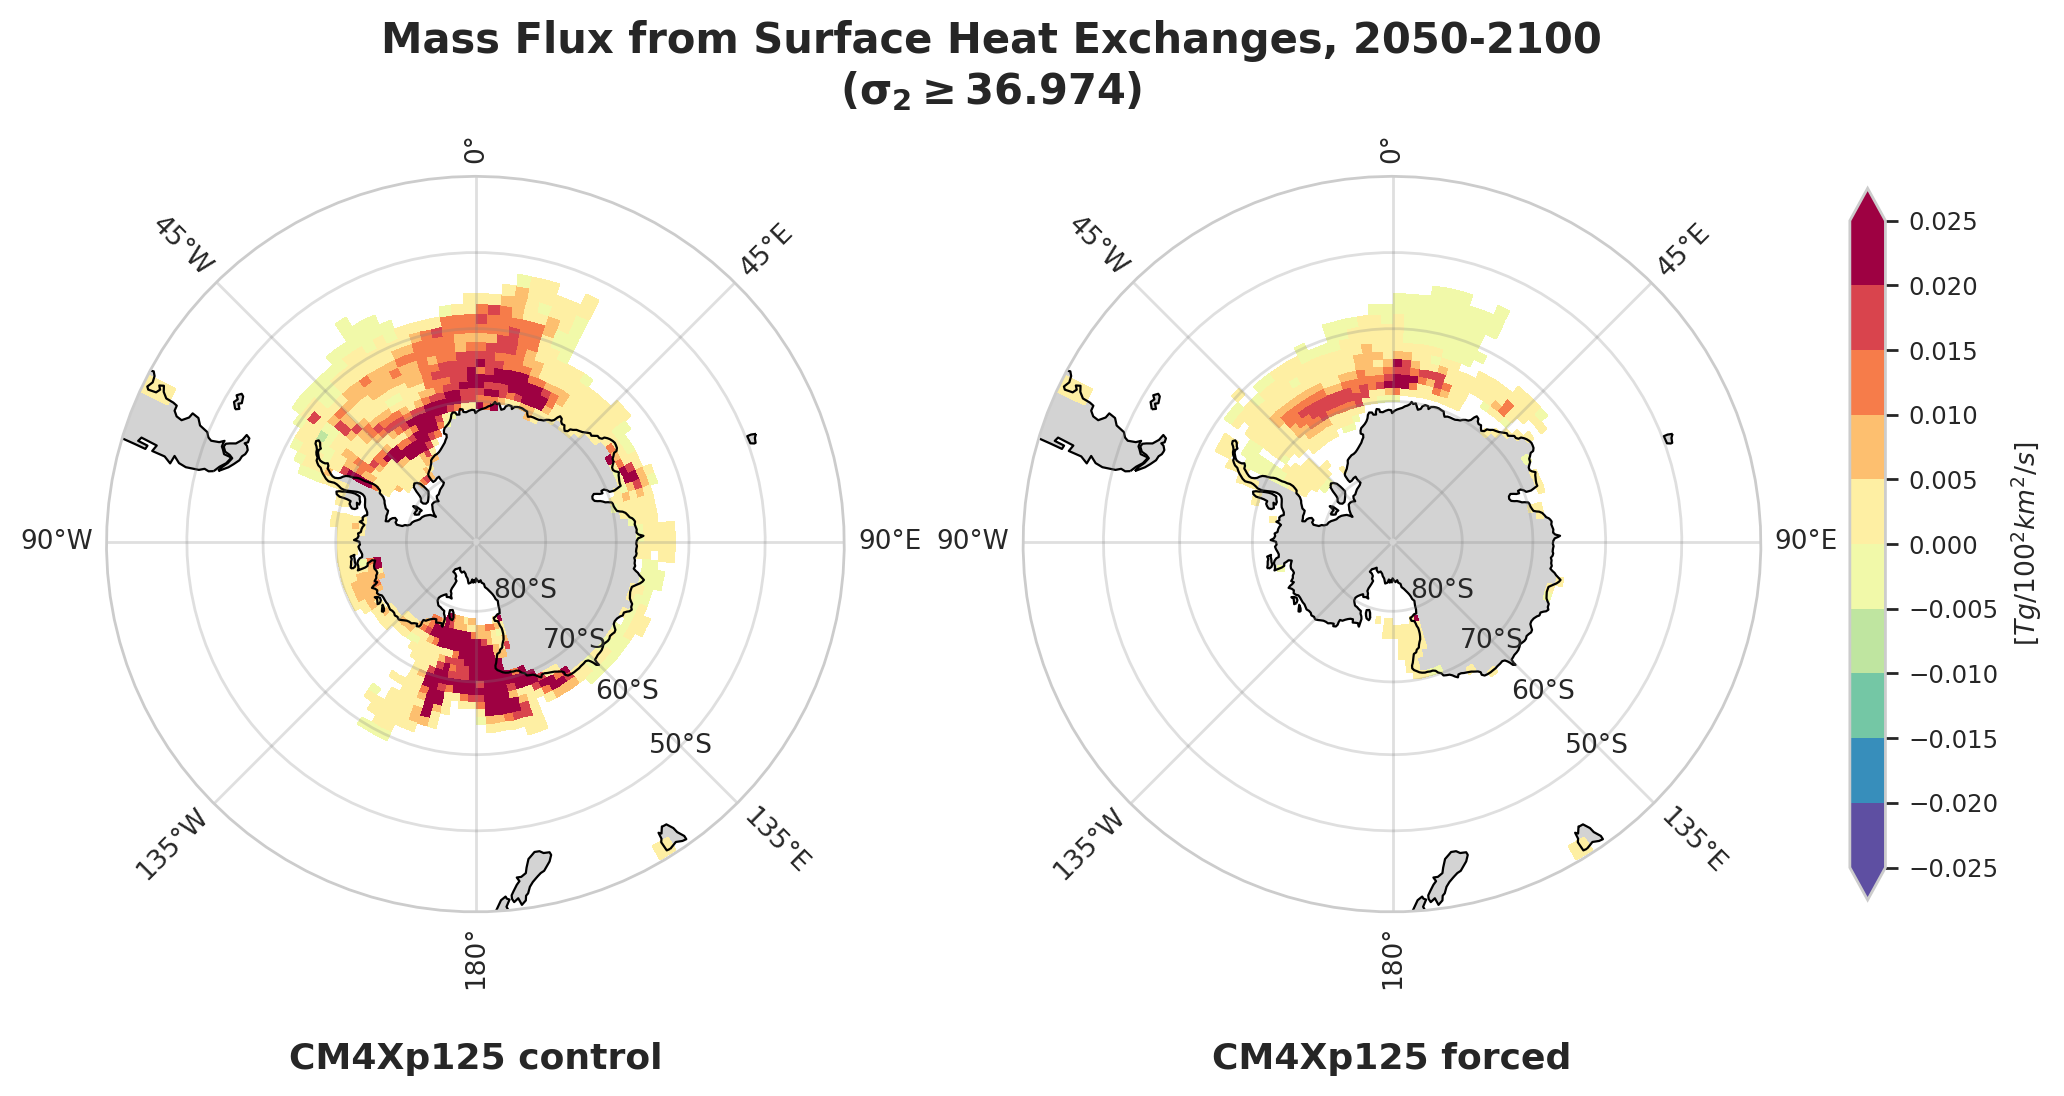

In [211]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = ("2050", "2100")

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):
    cm = plot_antarctic_plot(wmt_mean, ax[i], cmap = cmap, norm = norm, 
                       exp = exp, variable = "surface_exchange_flux_heat", 
                        mass_flux_units_conversion = mass_flux_units_conversion)
fig.suptitle("Mass Flux from Surface Heat Exchanges, " + '-'.join(times) + "\n" + density_title, 
             fontweight = "bold", fontsize = 15)


fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both", ticks=boundaries)

fig.savefig(plotsdir(f"paper_figures/GSFCheat_exchange_sigma_{sigma}_surface.png"), bbox_inches = "tight", dpi = dpi)

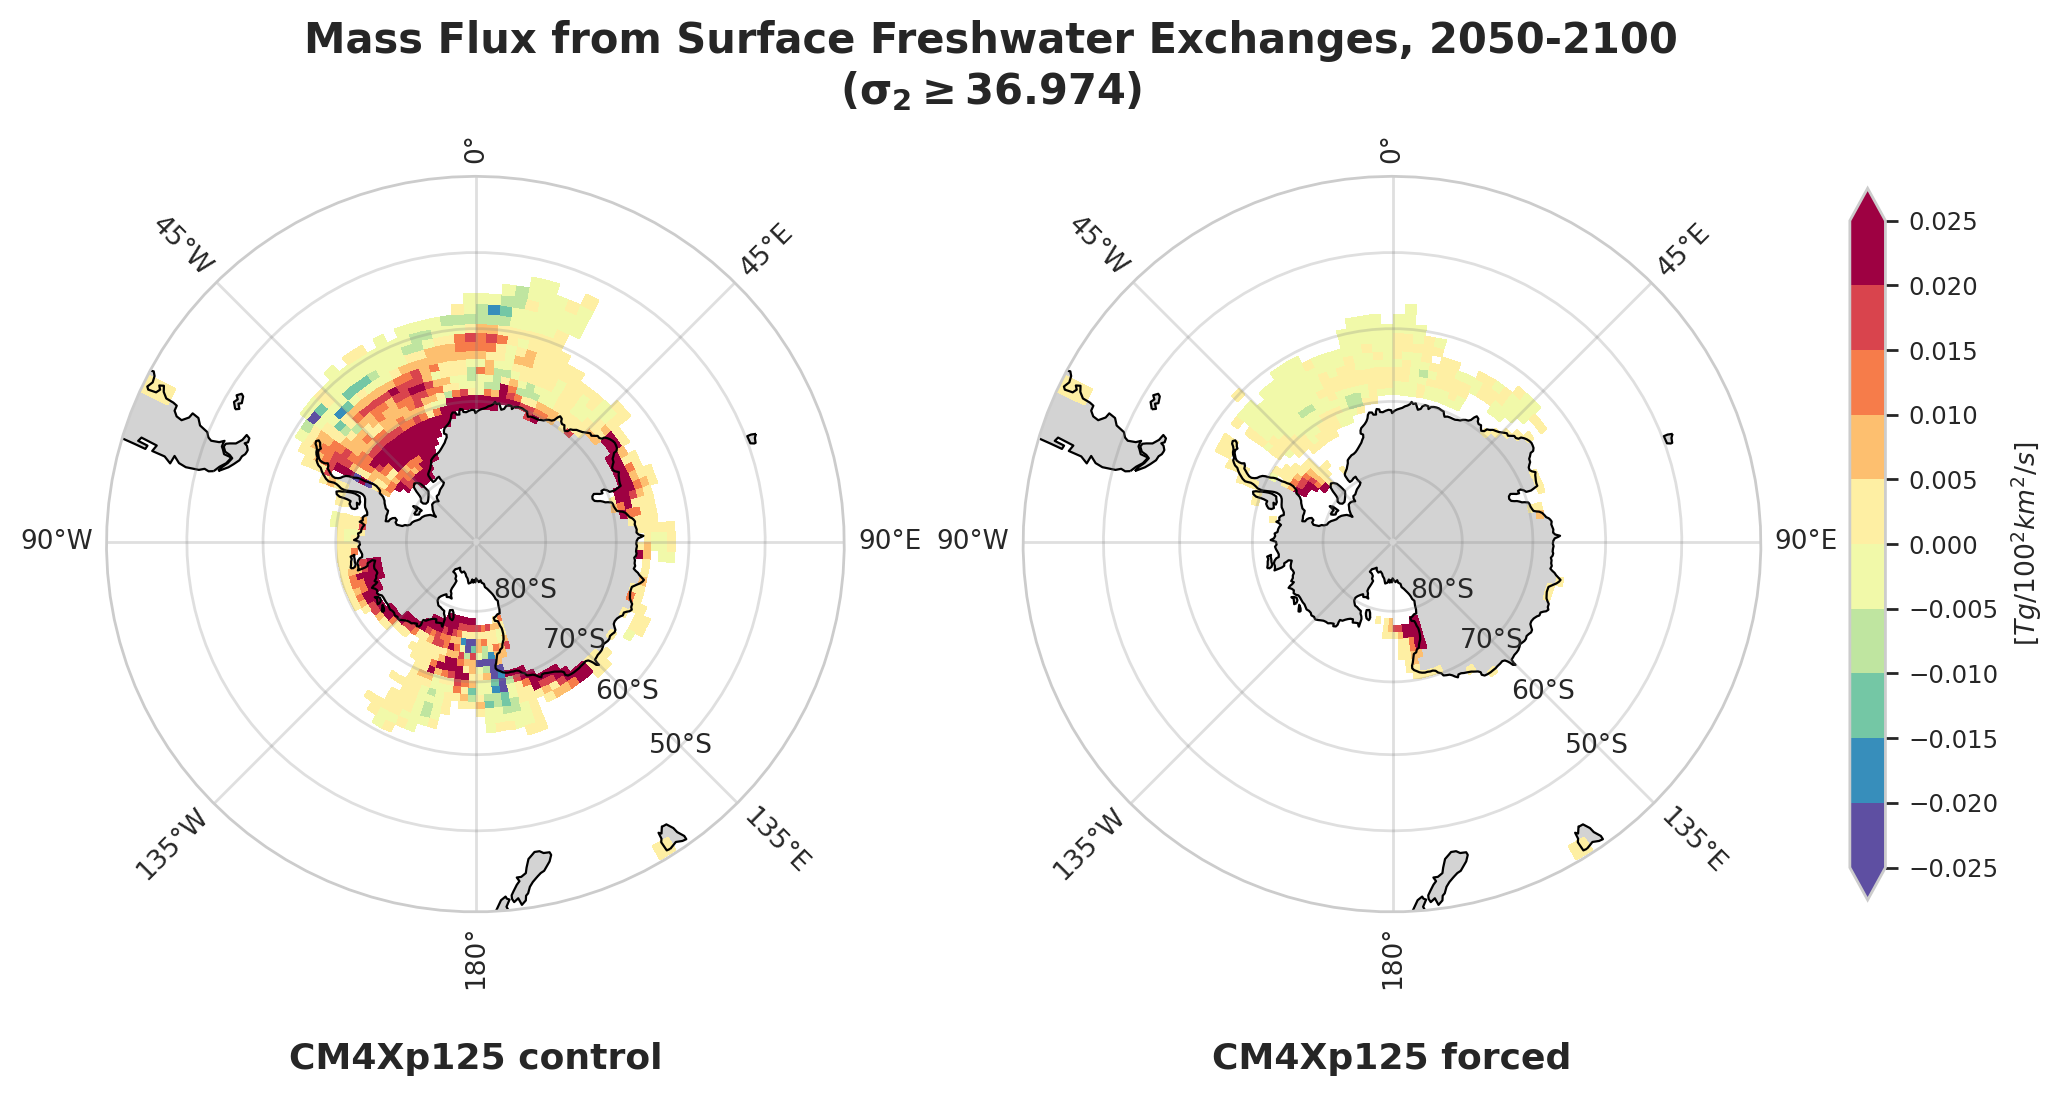

In [212]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = ("2050", "2100")

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):
    cm = plot_antarctic_plot(wmt_mean, ax[i], cmap = cmap, norm = norm, 
                       exp = exp, variable = "surface_ocean_flux_advective_negative_rhs_salt", 
                        mass_flux_units_conversion = mass_flux_units_conversion)
fig.suptitle("Mass Flux from Surface Freshwater Exchanges, " + '-'.join(times) + "\n" + density_title, 
             fontweight = "bold", fontsize = 15)


fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both", ticks=boundaries)

fig.savefig(plotsdir(f"paper_figures/GSFCFW_exchanges_sigma_{sigma}_surface.png"), bbox_inches = "tight", dpi = dpi)

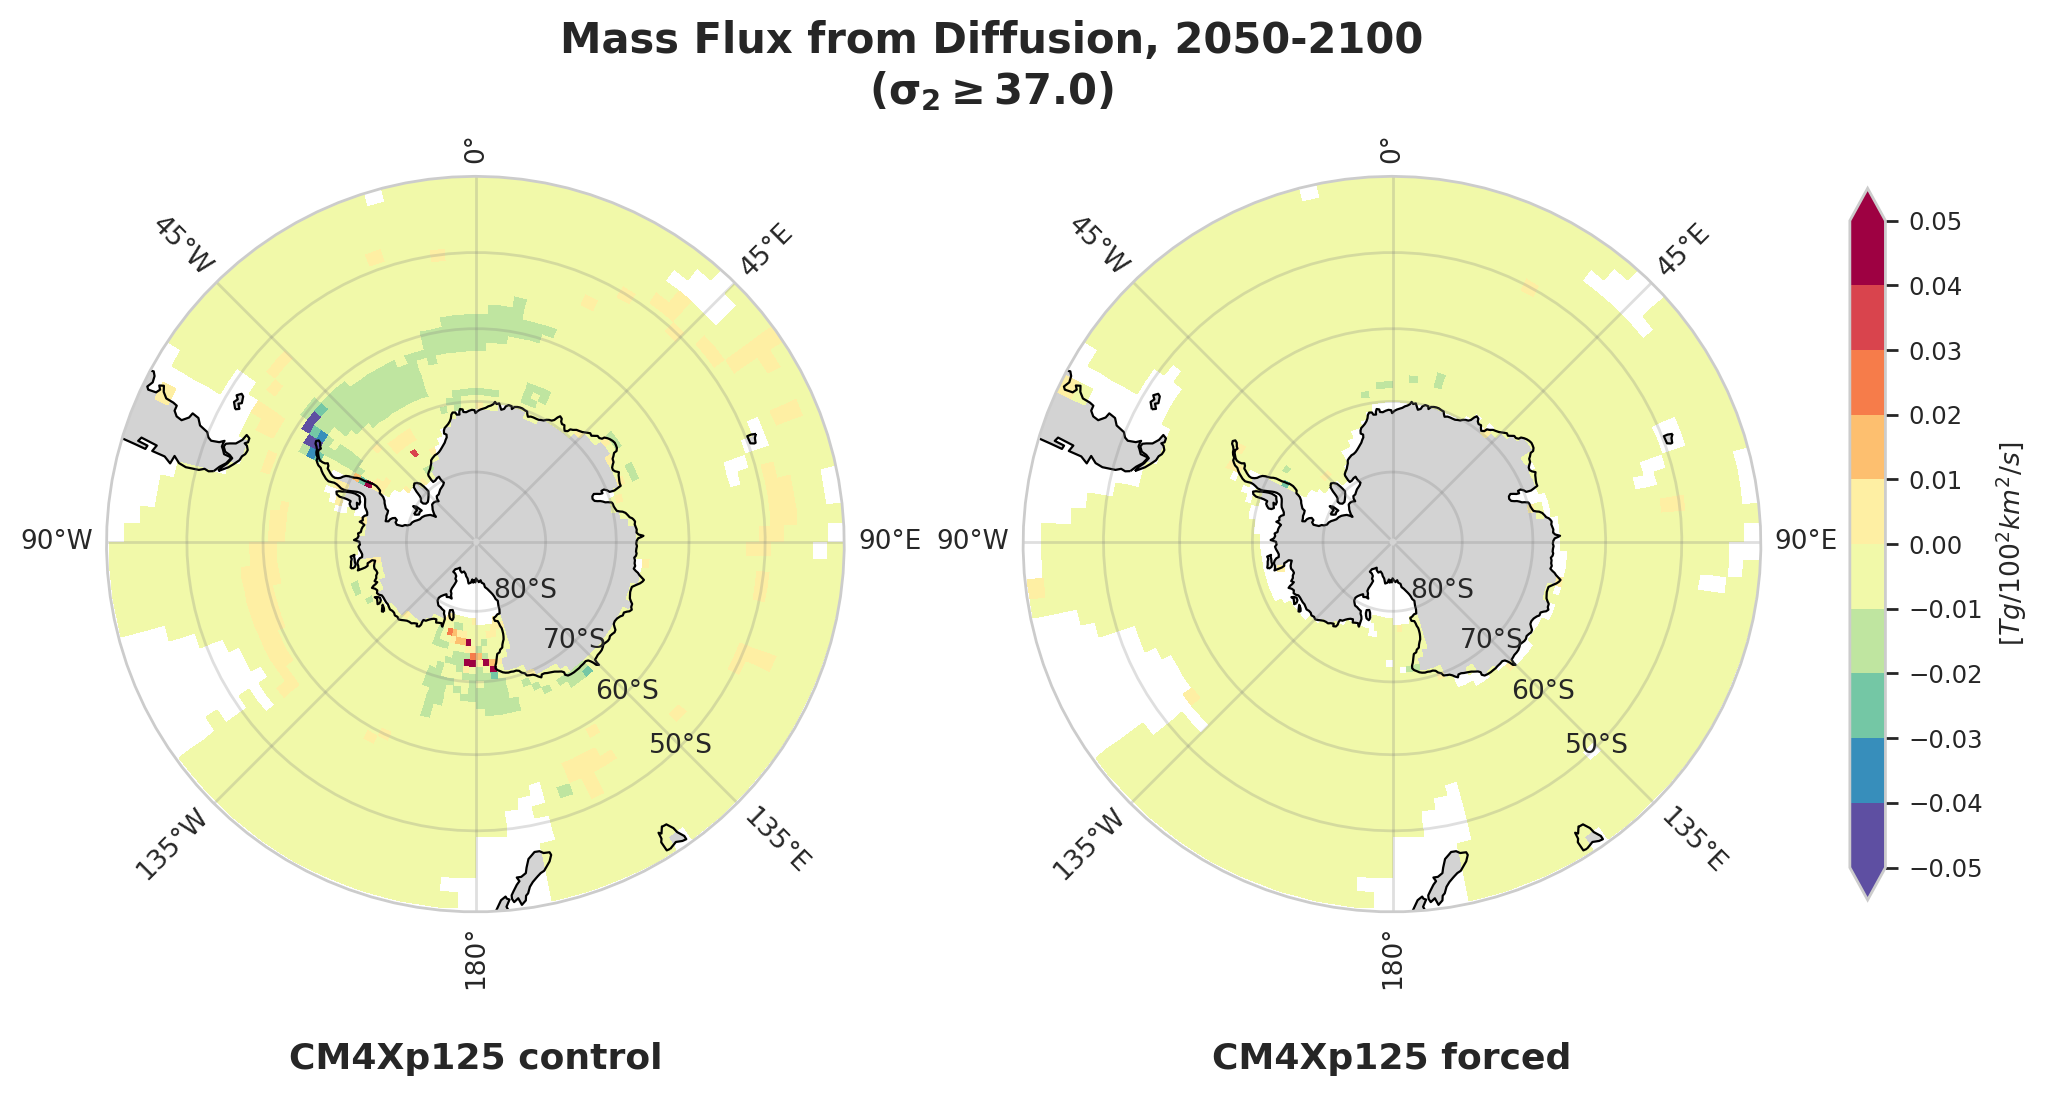

In [213]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = ("2050", "2100")

experiments = ['control', 'forced']
cmap = plt.get_cmap('Spectral_r')
boundaries = np.arange(-0.05, 0.0501, 0.01)
boundaries[np.abs(boundaries) < 1e-16]  = 0
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):
    cm = plot_antarctic_plot(wmt_mean, ax[i], cmap = cmap, norm = norm, 
                       exp = exp, variable = "diffusion", 
                        mass_flux_units_conversion = mass_flux_units_conversion)
    
fig.suptitle("Mass Flux from Diffusion, " + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq 37.0)}$", 
             fontweight = "bold", fontsize = 15)
fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both", ticks=boundaries)

fig.savefig(plotsdir(f"paper_figures/Gmix_sigma_{sigma}_surface.png"), bbox_inches = "tight", dpi = dpi)

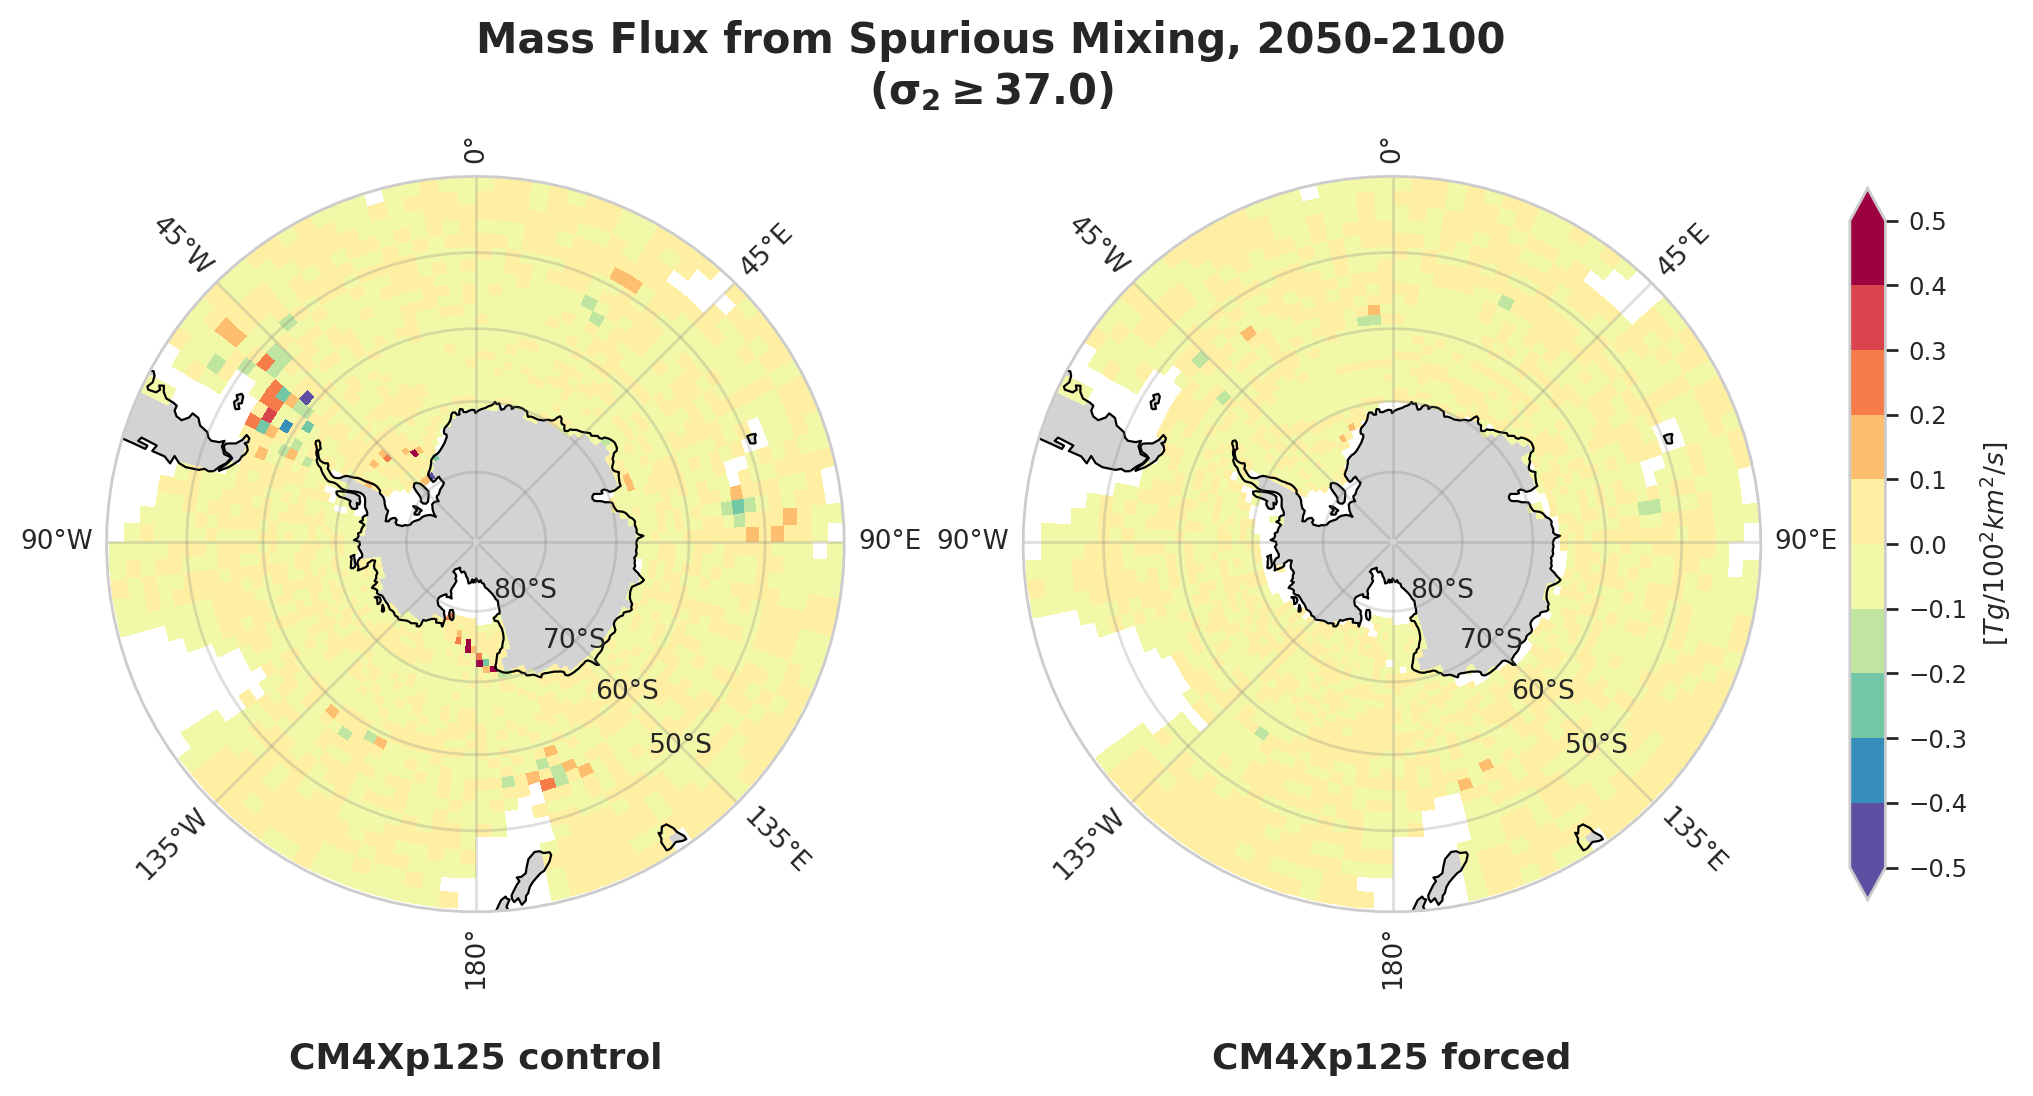

In [214]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = ("2050", "2100")

experiments = ['control', 'forced']
cmap = plt.get_cmap('Spectral_r')
boundaries = np.arange(-0.5, 0.501, 0.1)
boundaries[np.abs(boundaries) < 1e-16]  = 0

# boundaries = boundaries /2 
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):
    cm = plot_antarctic_plot(wmt_mean, ax[i], cmap = cmap, norm = norm, 
                       exp = exp, variable = "spurious_numerical_mixing", 
                        mass_flux_units_conversion = mass_flux_units_conversion)
fig.suptitle("Mass Flux from Spurious Mixing, " + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq 37.0)}$", 
             fontweight = "bold", fontsize = 15)


fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both", ticks=boundaries)

fig.savefig(plotsdir(f"paper_figures/Gspur_sigma_{sigma}_surface.png"), bbox_inches = "tight", dpi = dpi)

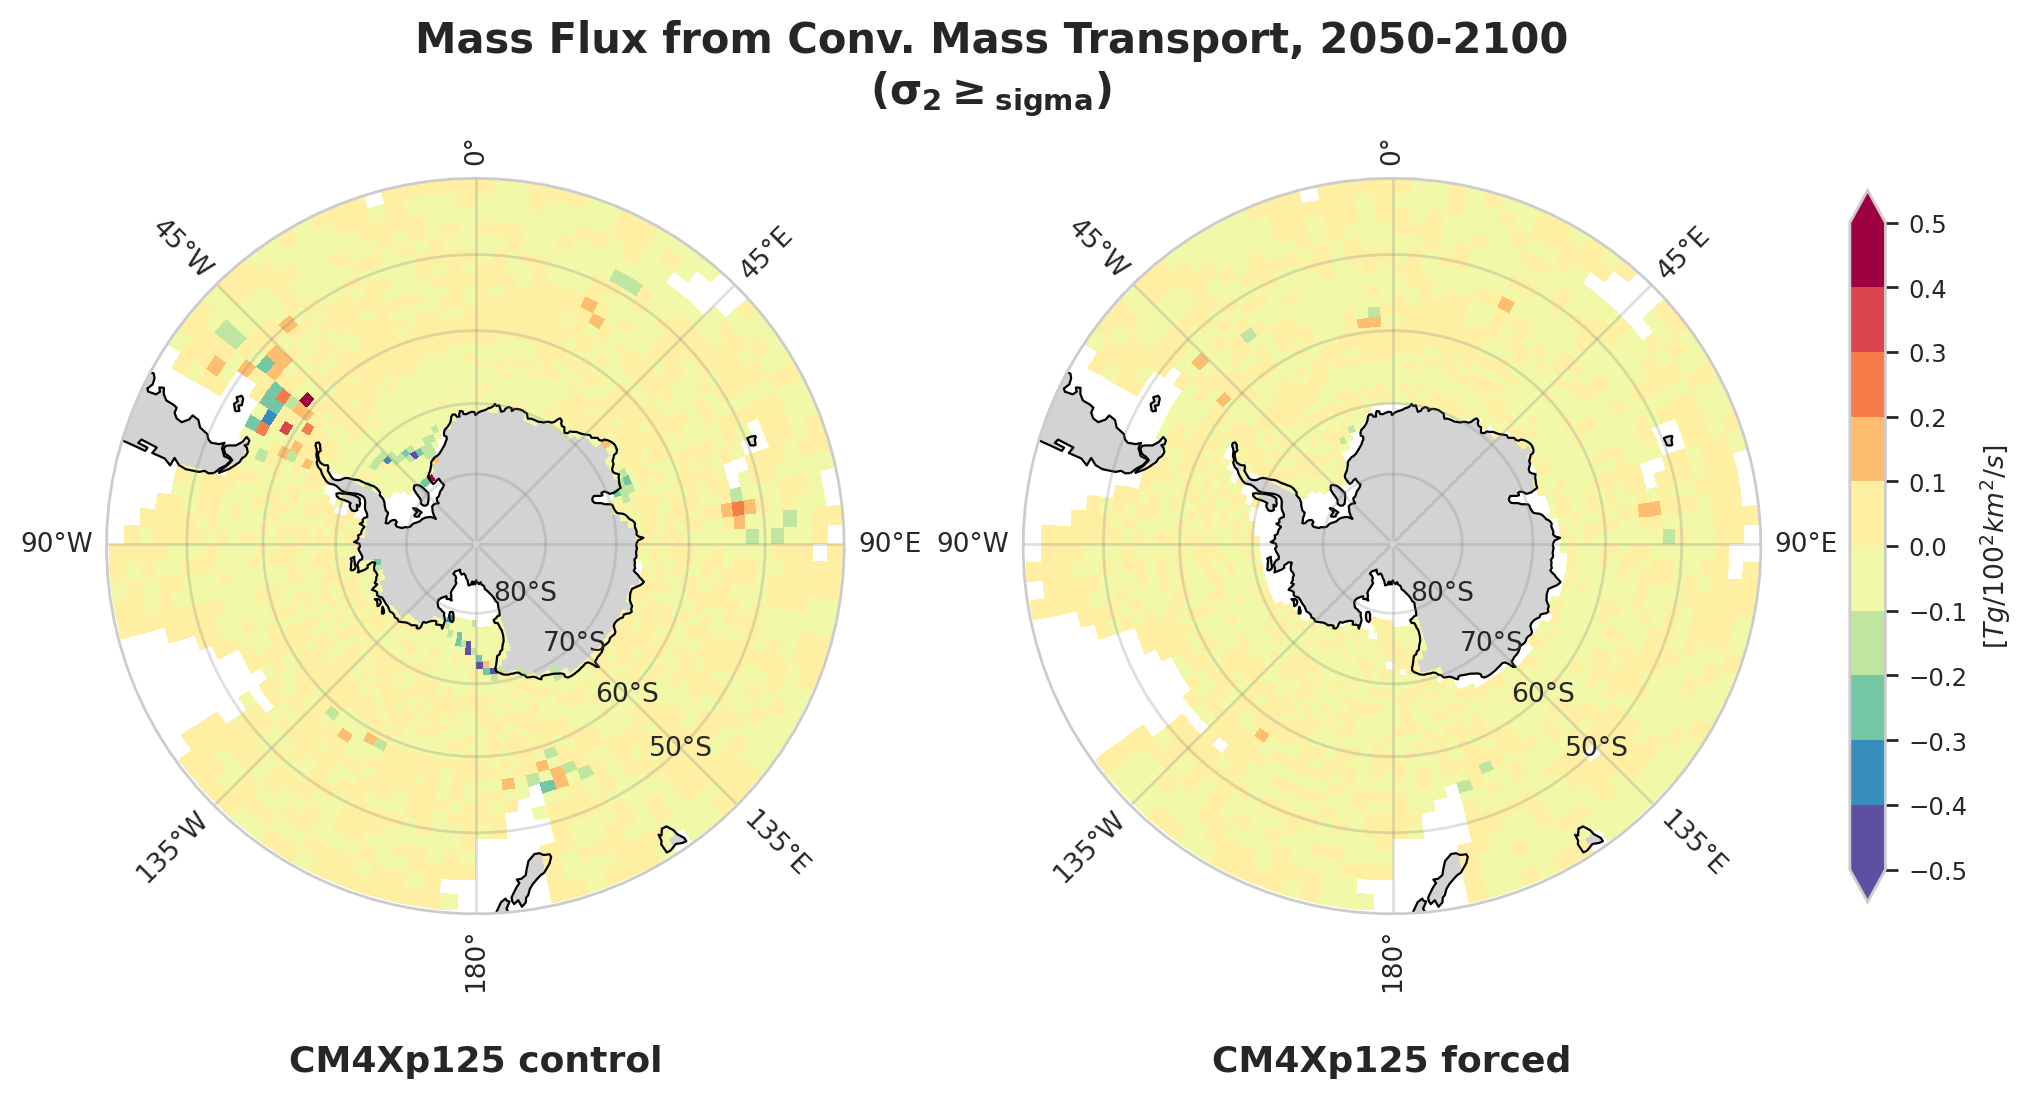

In [215]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = ("2050", "2100")

experiments = ['control', 'forced']
cmap = plt.get_cmap('Spectral_r')
boundaries = np.arange(-0.5, 0.501, 0.1)
boundaries[np.abs(boundaries) < 1e-16]  = 0

# boundaries = boundaries /2 
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):

    cm = plot_antarctic_plot(wmt_mean, ax[i], cmap = cmap, norm = norm, 
                       exp = exp, variable = "convergent_mass_transport", 
                        mass_flux_units_conversion = mass_flux_units_conversion)

fig.suptitle("Mass Flux from Conv. Mass Transport, " + '-'.join(times) + "\n" + r"$\mathbf{(\sigma_2 \geq _{sigma})}$", 
             fontweight = "bold", fontsize = 15)
fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both", ticks=boundaries)

fig.savefig(plotsdir(f"paper_figures/GPsi_sigma_{sigma}_surface.png"), bbox_inches = "tight", dpi = dpi)

control
diffusion
forced
diffusion
control
spurious_numerical_mixing
forced
spurious_numerical_mixing


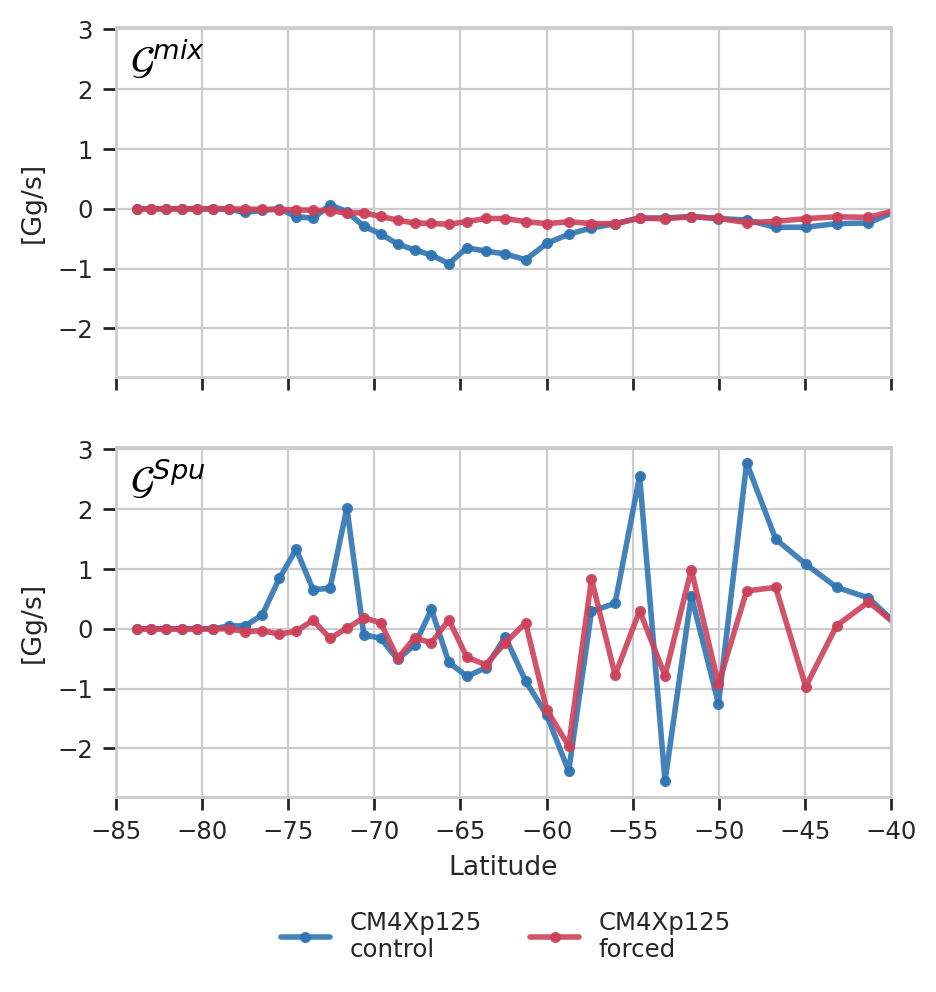

In [64]:
mass_flux_units = "Gg/s"
mass_flux_units_conversion = toTg

times = ('2050', '2100')
experiments = ['control', 'forced']
fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharey = True, sharex =True)

wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
vmax = np.abs(wmt_mean["spurious_numerical_mixing"]).max().values

variables = ["diffusion", "spurious_numerical_mixing"]

labels = [r"$\mathcal{G}^{mix}$", r"$\mathcal{G}^{Spu}$"]
for (j, var) in enumerate(variables):
    ax = axes[j]
    ax.annotate(labels[j], xy=(-85, 2.5), fontsize = 14, 
        xytext=(5, 0), textcoords="offset points",
      va="center", c = "k")
    for (i, expt) in enumerate(experiments):
        print(expt)
        print(var)

        wmt_mean_budget =  mass_flux_units_conversion * wmt_mean.sel(exp = expt)[var]
        wmt_mean_budget = wmt_mean_budget.where(wmt_mean_budget != 0.0).sum("xh")
        latitudes = wmt_mean["geolat"].mean("xh")
        bin_widths = np.concatenate([np.diff(latitudes)[[0]], np.diff(latitudes)])
        
        ax.plot(latitudes,wmt_mean_budget, linewidth = 2.0, alpha = 0.9, 
                c = expt_colors[expt], label = f"CM4Xp125\n{expt}", 
                marker = "o", markersize = 3)
        
        ax.tick_params(bottom=True, left=True)
        ax.set_ylabel(f"[{mass_flux_units}]")


axes[1].set_xlabel("Latitude")
axes[1].set_xlim((-85, -40))
axes[1].legend(ncols = 2, loc = (.2, -0.5), frameon = False)
fig.subplots_adjust(wspace = 0.1)
fig.savefig(plotsdir(f"paper_figures/GMixGSpur_sigma_{sigma}_latitude.png"), bbox_inches = "tight", dpi = dpi)